# HOG FROM SKIMAGE

---



[(645, 101, 23, 75), (921, 101, 49, 73), (1022, 103, 18, 60), (130, 104, 22, 70), (325, 105, 21, 59), (435, 106, 46, 68), (844, 106, 15, 63), (758, 107, 26, 67), (229, 108, 13, 61), (553, 108, 14, 65), (1020, 195, 54, 62), (939, 197, 48, 63), (838, 207, 56, 66), (548, 209, 51, 64), (751, 209, 57, 68), (225, 210, 56, 81), (655, 212, 55, 61), (329, 213, 53, 72), (441, 214, 64, 60), (123, 222, 52, 74), (1035, 302, 55, 86), (945, 314, 49, 66), (858, 322, 38, 58), (752, 326, 62, 77), (554, 329, 50, 76), (436, 332, 57, 70), (653, 332, 53, 65), (334, 338, 45, 58), (227, 339, 52, 67), (126, 347, 43, 56), (1035, 410, 68, 73), (959, 418, 37, 59), (863, 425, 42, 65), (767, 431, 38, 61), (445, 434, 42, 64), (656, 434, 51, 61), (553, 436, 46, 61), (329, 448, 51, 63), (235, 449, 39, 62), (132, 456, 35, 57), (1047, 500, 55, 75), (961, 508, 47, 66), (868, 518, 46, 62), (766, 520, 46, 67), (659, 531, 50, 69), (562, 534, 50, 70), (451, 538, 48, 73), (230, 552, 53, 70), (333, 553, 54, 74), (128, 564, 46,

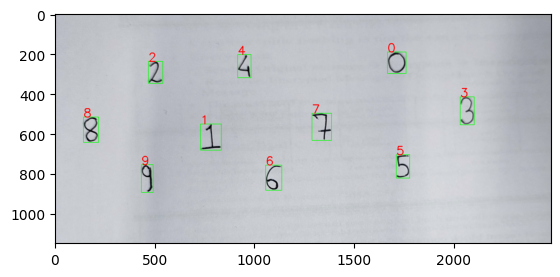

In [ ]:
from PIL import Image
from numpy import asarray

def imresize(arr,size):
	img=Image.fromarray(arr)
	img=img.resize(size)
	return asarray(img)

import numpy as np
from PIL import Image
import cv2
from skimage.feature import hog
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

DIGIT_WIDTH = 10
DIGIT_HEIGHT = 20
IMG_HEIGHT = 28
IMG_WIDTH = 28
CLASS_N = 10


def get_digits(contours, hierarchy):
    hierarchy = hierarchy[0]
    bounding_rectangles = [cv2.boundingRect(ctr) for ctr in contours]
    final_bounding_rectangles = []
    # find the most common heirarchy level - that is where our digits's bounding boxes are
    u, indices = np.unique(hierarchy[:, -1], return_inverse=True)
    most_common_heirarchy = u[np.argmax(np.bincount(indices))]

    for r, hr in zip(bounding_rectangles, hierarchy):
        x, y, w, h = r

        if ((w * h) > 250) and (10 <= w <= 200) and (10 <= h <= 200) and hr[3] == most_common_heirarchy:
            final_bounding_rectangles.append(r)

    return final_bounding_rectangles


def proc_user_img(img_file, model):
    print('loading "%s for digit recognition" ...' % img_file)
    im = cv2.imread(img_file)
    blank_image = np.zeros((im.shape[0], im.shape[1], 3), np.uint8)
    blank_image.fill(255)

    imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    plt.imshow(imgray)
    kernel = np.ones((5, 5), np.uint8)

    ret, thresh = cv2.threshold(imgray, 127, 255, 0)
    thresh = cv2.erode(thresh, kernel, iterations=1)
    thresh = cv2.dilate(thresh, kernel, iterations=1)
    thresh = cv2.erode(thresh, kernel, iterations=1)

    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    digits_rectangles = get_digits(contours, hierarchy)  # rectangles of bounding the digits in user image

    for rect in digits_rectangles:
        x, y, w, h = rect
        cv2.rectangle(im, (x, y), (x + w, y + h), (0, 255, 0), 2)
        im_digit = imgray[y:y + h, x:x + w]
        im_digit = (255 - im_digit)
        im_digit = imresize(im_digit, (IMG_WIDTH, IMG_HEIGHT))

        hog_img_data = pixels_to_hog_20([im_digit])
        pred = model.predict(hog_img_data)
        cv2.putText(im, str(int(pred[0])), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 3)
        cv2.putText(blank_image, str(int(pred[0])), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 0, 0), 5)

    plt.imshow(im)
    cv2.imwrite("original_overlay.png", im)
    cv2.imwrite("final_digits.png", blank_image)
    # cv2.destroyAllWindows()


def get_contour_precedence(contour, cols):
    return contour[1] * cols + contour[0]  # row-wise ordering

def load_digits_custom(img_file):
    train_data = []
    train_target = []
    start_class = 1
    im = cv2.imread(img_file)
    imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    plt.imshow(imgray)
    kernel = np.ones((5, 5), np.uint8)

    ret, thresh = cv2.threshold(imgray, 127, 255, 0)
    thresh = cv2.erode(thresh, kernel, iterations=1)
    thresh = cv2.dilate(thresh, kernel, iterations=1)
    thresh = cv2.erode(thresh, kernel, iterations=1)

    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    digits_rectangles = get_digits(contours, hierarchy)  # rectangles of bounding the digits in user image

    # sort rectangles accoring to x,y pos so that we can label them
    digits_rectangles.sort(key=lambda x: get_contour_precedence(x, im.shape[1]))
    print(digits_rectangles)
    for index, rect in enumerate(digits_rectangles):
        x, y, w, h = rect
        cv2.rectangle(im, (x, y), (x + w, y + h), (0, 255, 0), 2)
        im_digit = imgray[y:y + h, x:x + w]
        im_digit = (255 - im_digit)

        im_digit = imresize(im_digit, (IMG_WIDTH, IMG_HEIGHT))
        train_data.append(im_digit)
        train_target.append(start_class % 10)

        if index > 0 and (index + 1) % 10 ==0:
            start_class += 1
    cv2.imwrite("training_box_overlay.png", im)

    return np.array(train_data), np.array(train_target)

# This method splits the input training image into small cells (of a single digit) and uses these cells as training data.
# The default training image (MNIST) is a 1000x1000 size image and each digit is of size 10x20, so we divide 1000/10 horizontally and 1000/20 vertically.
def split2d(img, cell_size, flatten=True):
    h, w = img.shape[:2]
    sx, sy = cell_size
    cells = [np.hsplit(row, w // sx) for row in np.vsplit(img, h // sy)]
    cells = np.array(cells)
    if flatten:
        cells = cells.reshape(-1, sy, sx)
    return cells


def load_digits(fn):
    print('loading "%s for training" ...' % fn)
    digits_img = cv2.imread(fn, 0)
    digits = split2d(digits_img, (DIGIT_WIDTH, DIGIT_HEIGHT))
    resized_digits = []
    for digit in digits:
        resized_digits.append(imresize(digit, (IMG_WIDTH, IMG_HEIGHT)))
    labels = np.repeat(np.arange(CLASS_N), len(digits) / CLASS_N)
    return np.array(resized_digits), labels

def pixels_to_hog_20(img_array):
    hog_featuresData = []
    for img in img_array:
        fd = hog(img,
                 orientations=10,
                 pixels_per_cell=(5, 5),
                 cells_per_block=(1, 1))
        hog_featuresData.append(fd)
    hog_features = np.array(hog_featuresData, 'float64')
    return np.float32(hog_features)


TRAIN_MNIST_IMG = '/content/digits.png'
TRAIN_USER_IMG = '/content/custom_train_digits_k1.jpg'
TEST_USER_IMG = '/content/handwritten_testing_keshavjpg.jpg'

# digits, labels = load_digits(TRAIN_MNIST_IMG) #original MNIST data (not good detection)
digits, labels = load_digits_custom(
    TRAIN_USER_IMG)  # my handwritten dataset (better than MNIST on my handwritten digits)

print('train data shape', digits.shape)
print('test data shape', labels.shape)

digits, labels = shuffle(digits, labels, random_state=256)
train_digits_data = pixels_to_hog_20(digits)
X_train, X_test, y_train, y_test = train_test_split(train_digits_data, labels, test_size=0.33, random_state=42)

# define a custom model in a similar class wrapper with train and predict methods
class KNN_MODEL():
    def __init__(self, k=3):
        self.k = k
        self.model = cv2.ml.KNearest_create()

    def train(self, samples, responses):
        self.model.train(samples, cv2.ml.ROW_SAMPLE, responses)

    def predict(self, samples):
        retval, results, neigh_resp, dists = self.model.findNearest(samples, self.k)
        return results.ravel()


class SVM_MODEL():
    def __init__(self, num_feats, C=1, gamma=0.1):
        self.model = cv2.ml.SVM_create()
        self.model.setType(cv2.ml.SVM_C_SVC)
        self.model.setKernel(cv2.ml.SVM_RBF)  # SVM_LINEAR, SVM_RBF
        self.model.setC(C)
        self.model.setGamma(gamma)
        self.features = num_feats

    def train(self, samples, responses):
        self.model.train(samples, cv2.ml.ROW_SAMPLE, responses)

    def predict(self, samples):
        results = self.model.predict(samples.reshape(-1, self.features))
        return results[1].ravel()

# training and testing

model = KNN_MODEL(k=3)
model.train(X_train, y_train)
preds = model.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, preds))

model = KNN_MODEL(k=4)
model.train(train_digits_data, labels)
proc_user_img(TEST_USER_IMG, model)

model = SVM_MODEL(num_feats=train_digits_data.shape[1])
model.train(X_train, y_train)
preds = model.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, preds))

model = SVM_MODEL(num_feats=train_digits_data.shape[1])
model.train(train_digits_data, labels)
proc_user_img(TEST_USER_IMG, model)

# USING LBP INSTEAD OF HOG

---




train data shape (100, 28, 28)
test data shape (100,)
KNN Accuracy:  0.3333333333333333
loading "/content/handwritten_testing_keshavjpg.jpg for digit recognition" ...


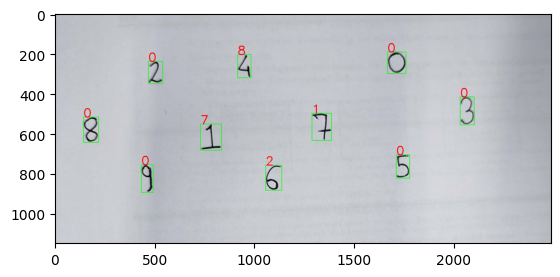

In [ ]:
from PIL import Image
import numpy as np
import cv2
from skimage.feature import local_binary_pattern
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

DIGIT_WIDTH = 10
DIGIT_HEIGHT = 20
IMG_HEIGHT = 28
IMG_WIDTH = 28
CLASS_N = 10  # 0-9


def imresize(arr, size):
    img = Image.fromarray(arr)
    img = img.resize(size)
    return np.array(img)


def split2d(img, cell_size, flatten=True):
    h, w = img.shape[:2]
    sx, sy = cell_size
    cells = [np.hsplit(row, w // sx) for row in np.vsplit(img, h // sy)]
    cells = np.array(cells)
    if flatten:
        cells = cells.reshape(-1, sy, sx)
    return cells


def load_digits(fn):
    print('loading "%s for training" ...' % fn)
    digits_img = cv2.imread(fn, 0)
    digits = split2d(digits_img, (DIGIT_WIDTH, DIGIT_HEIGHT))
    resized_digits = []
    for digit in digits:
        resized_digits.append(imresize(digit, (IMG_WIDTH, IMG_HEIGHT)))
    labels = np.repeat(np.arange(CLASS_N), len(digits) / CLASS_N)
    return np.array(resized_digits), labels


def pixels_to_lbp(img_array):
    lbp_featuresData = []
    for img in img_array:
        lbp_img = local_binary_pattern(img, 8, 1, method='uniform')
        hist, _ = np.histogram(lbp_img.ravel(), bins=np.arange(0, 10), range=(0, 9))
        lbp_featuresData.append(hist)
    lbp_features = np.array(lbp_featuresData, 'float64')
    return np.float32(lbp_features)


class KNN_MODEL():
    def __init__(self, k=3):
        self.k = k
        self.model = cv2.ml.KNearest_create()

    def train(self, samples, responses):
        self.model.train(samples, cv2.ml.ROW_SAMPLE, responses)

    def predict(self, samples):
        retval, results, neigh_resp, dists = self.model.findNearest(samples, self.k)
        return results.ravel()


class SVM_MODEL():
    def __init__(self, num_feats, C=1, gamma=0.1):
        self.model = cv2.ml.SVM_create()
        self.model.setType(cv2.ml.SVM_C_SVC)
        self.model.setKernel(cv2.ml.SVM_RBF)  # SVM_LINEAR, SVM_RBF
        self.model.setC(C)
        self.model.setGamma(gamma)
        self.features = num_feats

    def train(self, samples, responses):
        self.model.train(samples, cv2.ml.ROW_SAMPLE, responses)

    def predict(self, samples):
        results = self.model.predict(samples.reshape(-1, self.features))
        return results[1].ravel()


def get_digits(contours, hierarchy):
    hierarchy = hierarchy[0]
    bounding_rectangles = [cv2.boundingRect(ctr) for ctr in contours]
    final_bounding_rectangles = []
    u, indices = np.unique(hierarchy[:, -1], return_inverse=True)
    most_common_heirarchy = u[np.argmax(np.bincount(indices))]

    for r, hr in zip(bounding_rectangles, hierarchy):
        x, y, w, h = r
        if ((w * h) > 250) and (10 <= w <= 200) and (10 <= h <= 200) and hr[3] == most_common_heirarchy:
            final_bounding_rectangles.append(r)

    return final_bounding_rectangles


def proc_user_img(img_file, model):
    print('loading "%s for digit recognition" ...' % img_file)
    im = cv2.imread(img_file)
    blank_image = np.zeros((im.shape[0], im.shape[1], 3), np.uint8)
    blank_image.fill(255)

    imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    kernel = np.ones((5, 5), np.uint8)

    ret, thresh = cv2.threshold(imgray, 127, 255, 0)
    thresh = cv2.erode(thresh, kernel, iterations=1)
    thresh = cv2.dilate(thresh, kernel, iterations=1)
    thresh = cv2.erode(thresh, kernel, iterations=1)

    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    digits_rectangles = get_digits(contours, hierarchy)

    for rect in digits_rectangles:
        x, y, w, h = rect
        cv2.rectangle(im, (x, y), (x + w, y + h), (0, 255, 0), 2)
        im_digit = imgray[y:y + h, x:x + w]
        im_digit = (255 - im_digit)
        im_digit = imresize(im_digit, (IMG_WIDTH, IMG_HEIGHT))

        lbp_img_data = pixels_to_lbp([im_digit])
        pred = model.predict(lbp_img_data)
        cv2.putText(im, str(int(pred[0])), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 3)
        cv2.putText(blank_image, str(int(pred[0])), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 0, 0), 5)

    plt.imshow(im)
    cv2.imwrite("original_overlay.png", im)
    cv2.imwrite("final_digits.png", blank_image)


def get_contour_precedence(contour, cols):
    return contour[1] * cols + contour[0]


def load_digits_custom(img_file):
    train_data = []
    train_target = []
    start_class = 1
    im = cv2.imread(img_file)
    imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    kernel = np.ones((5, 5), np.uint8)

    ret, thresh = cv2.threshold(imgray, 127, 255, 0)
    thresh = cv2.erode(thresh, kernel, iterations=1)
    thresh = cv2.dilate(thresh, kernel, iterations=1)
    thresh = cv2.erode(thresh, kernel, iterations=1)

    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    digits_rectangles = get_digits(contours, hierarchy)

    digits_rectangles.sort(key=lambda x: get_contour_precedence(x, im.shape[1]))

    for index, rect in enumerate(digits_rectangles):
        x, y, w, h = rect
        cv2.rectangle(im, (x, y), (x + w, y + h), (0, 255, 0), 2)
        im_digit = imgray[y:y + h, x:x + w]
        im_digit = (255 - im_digit)

        im_digit = imresize(im_digit, (IMG_WIDTH, IMG_HEIGHT))
        train_data.append(im_digit)
        train_target.append(start_class % 10)

        if index > 0 and (index + 1) % 10 == 0:
            start_class += 1
    cv2.imwrite("training_box_overlay.png", im)

    return np.array(train_data), np.array(train_target)


TRAIN_USER_IMG = '/content/custom_train_digits_k1.jpg'
TEST_USER_IMG = '/content/handwritten_testing_keshavjpg.jpg'

digits, labels = load_digits_custom(TRAIN_USER_IMG)

print('train data shape', digits.shape)
print('test data shape', labels.shape)

digits, labels = shuffle(digits, labels, random_state=256)
train_digits_data = pixels_to_lbp(digits)
X_train, X_test, y_train, y_test = train_test_split(train_digits_data, labels, test_size=0.33, random_state=42)

model = KNN_MODEL(k=3)
model.train(X_train, y_train)
preds = model.predict(X_test)
print('KNN Accuracy: ', accuracy_score(y_test, preds))

# model = SVM_MODEL(num_feats=train_digits_data.shape[1])
# model.train(X_train, y_train)
# preds = model.predict(X_test)
# print('SVM Accuracy: ', accuracy_score(y_test, preds))

proc_user_img(TEST_USER_IMG, model)


# VISUALISATIONS

---



KNN Accuracy:  1.0
SVM Accuracy:  0.9696969696969697
Confusion matrix, without normalization


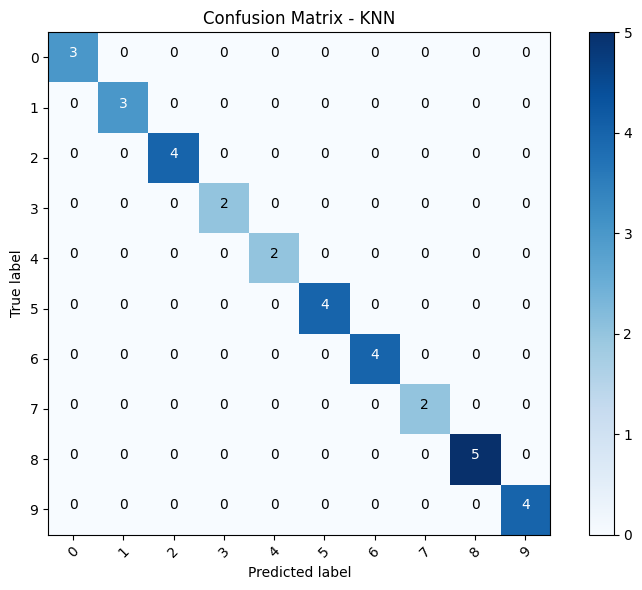

Confusion matrix, without normalization


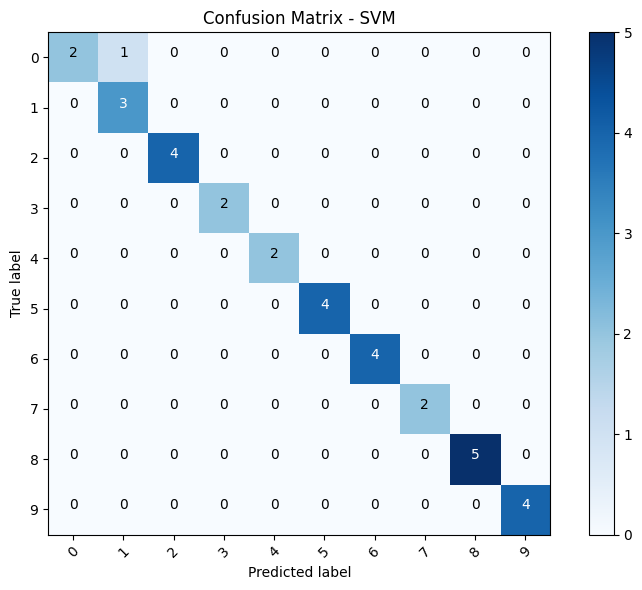

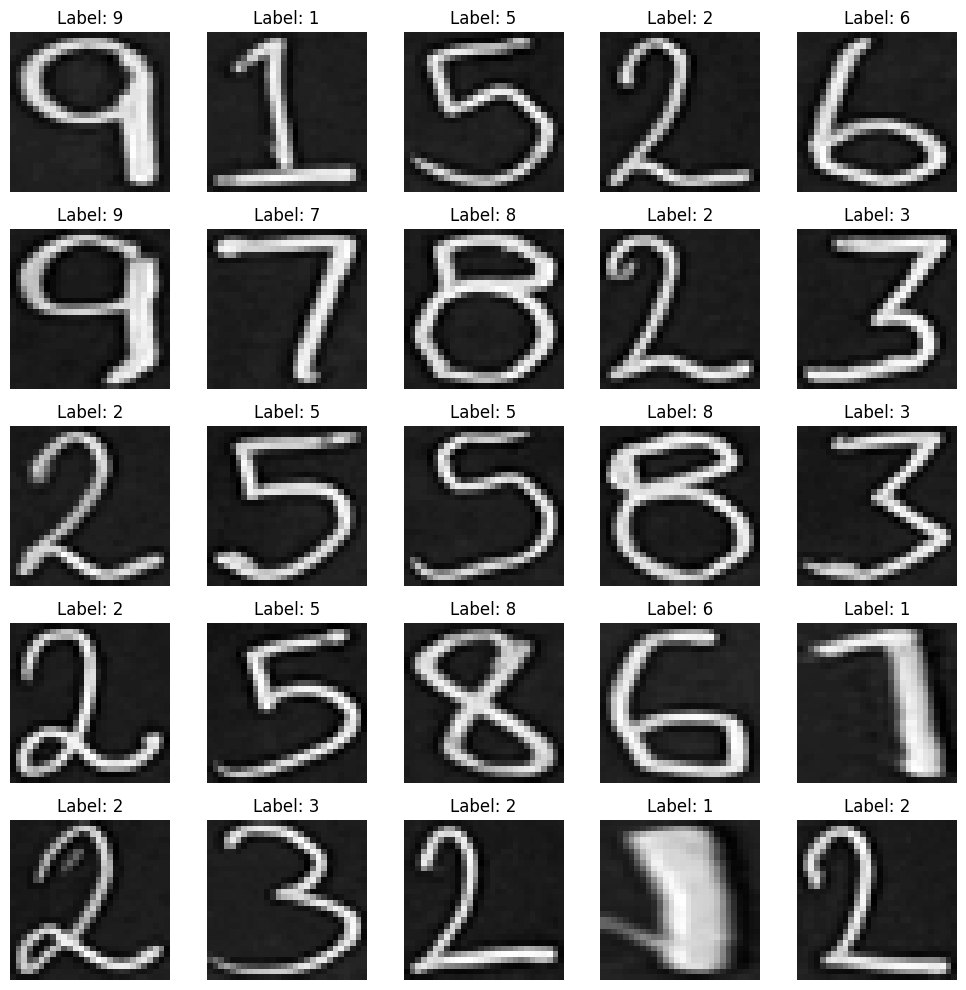

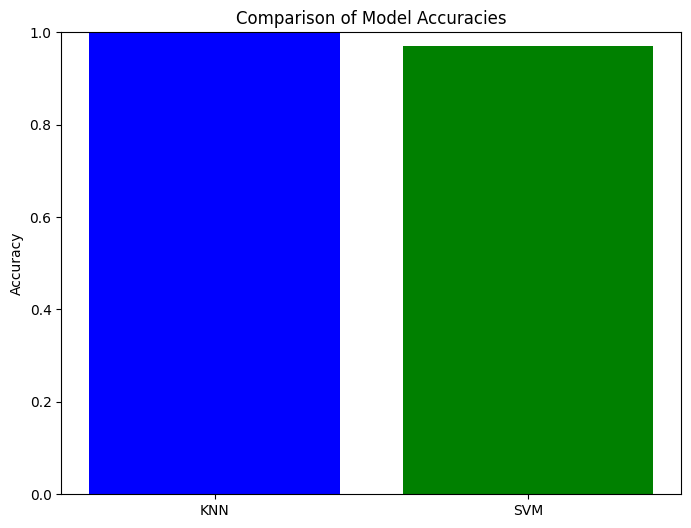

In [ ]:
import numpy as np
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

# Add the necessary imports for visualization
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import itertools

DIGIT_WIDTH = 10
DIGIT_HEIGHT = 20
IMG_HEIGHT = 28
IMG_WIDTH = 28
CLASS_N = 10  # 0-9

# Define a function to load digits and labels
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
def load_digits_custom(img_file):
    train_data = []
    train_target = []
    start_class = 1
    im = cv2.imread(img_file)
    imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    kernel = np.ones((5, 5), np.uint8)

    ret, thresh = cv2.threshold(imgray, 127, 255, 0)
    thresh = cv2.erode(thresh, kernel, iterations=1)
    thresh = cv2.dilate(thresh, kernel, iterations=1)
    thresh = cv2.erode(thresh, kernel, iterations=1)

    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    digits_rectangles = get_digits(contours, hierarchy)

    digits_rectangles.sort(key=lambda x: get_contour_precedence(x, im.shape[1]))

    for index, rect in enumerate(digits_rectangles):
        x, y, w, h = rect
        im_digit = (255 - imgray[y:y + h, x:x + w])
        im_digit = imresize(im_digit, (IMG_WIDTH, IMG_HEIGHT))
        train_data.append(im_digit)
        train_target.append(start_class % 10)
        if index > 0 and (index + 1) % 10 == 0:
            start_class += 1
    return np.array(train_data), np.array(train_target)

# Load custom training data
TRAIN_USER_IMG = '/content/custom_train_digits_k1.jpg'
digits, labels = load_digits_custom(TRAIN_USER_IMG)
digits, labels = shuffle(digits, labels, random_state=256)
train_digits_data = pixels_to_hog_20(digits)
X_train, X_test, y_train, y_test = train_test_split(train_digits_data, labels, test_size=0.33, random_state=42)

# Train and evaluate KNN model
knn_model = KNN_MODEL(k=3)
knn_model.train(X_train, y_train)
knn_preds = knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_preds)
print('KNN Accuracy: ', knn_accuracy)

# Train and evaluate SVM model
svm_model = SVM_MODEL(num_feats=train_digits_data.shape[1])
svm_model.train(X_train, y_train)
svm_preds = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_preds)
print('SVM Accuracy: ', svm_accuracy)

# Plotting confusion matrix for KNN model
knn_confusion_matrix = confusion_matrix(y_test, knn_preds)
plt.figure(figsize=(8, 6))
plot_confusion_matrix(knn_confusion_matrix, classes=range(10), title='Confusion Matrix - KNN')
plt.show()

# Plotting confusion matrix for SVM model
svm_confusion_matrix = confusion_matrix(y_test, svm_preds)
plt.figure(figsize=(8, 6))
plot_confusion_matrix(svm_confusion_matrix, classes=range(10), title='Confusion Matrix - SVM')
plt.show()

# Visualization of the first 25 digits in the training dataset
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(digits[i], cmap='gray')
    ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

# Comparison of model accuracies
models = ['KNN', 'SVM']
accuracies = [knn_accuracy, svm_accuracy]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['blue', 'green'])
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.ylim(0, 1)
plt.show()


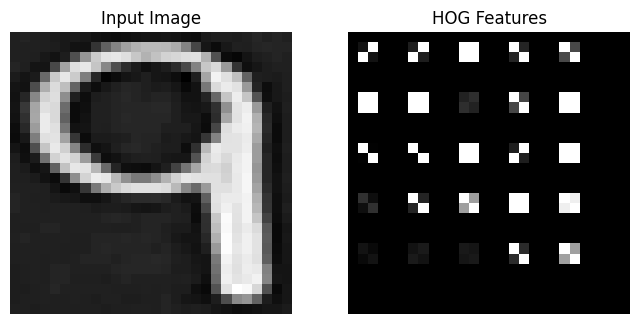

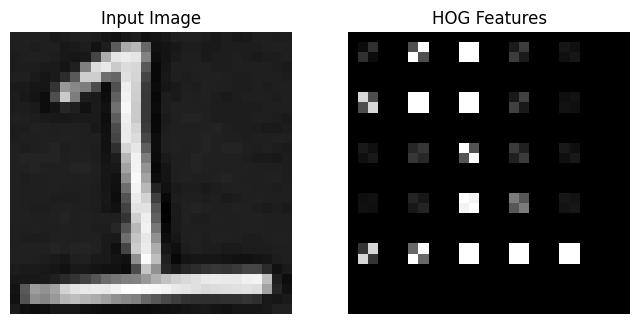

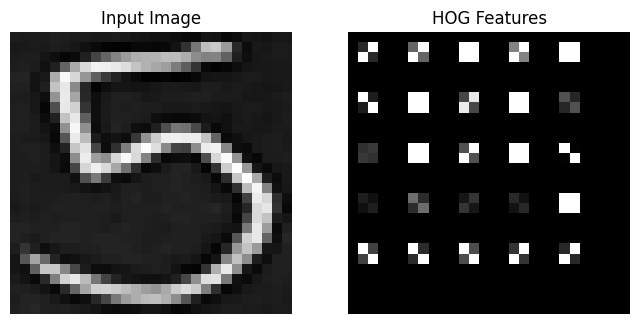

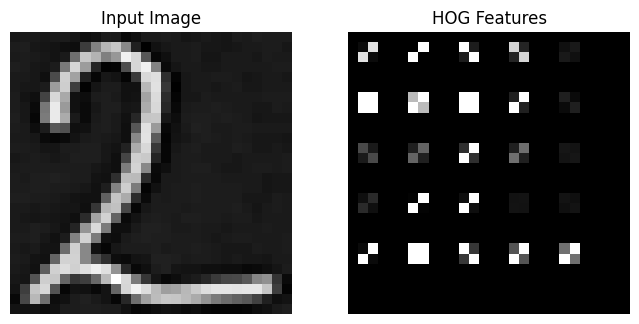

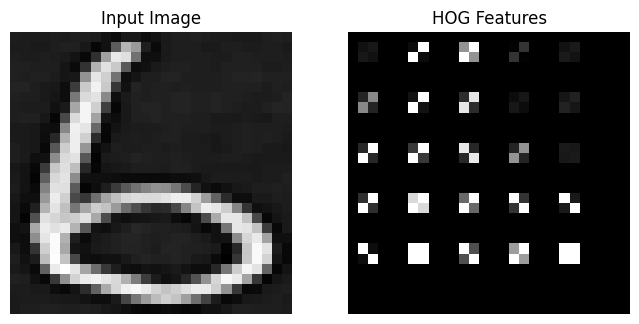

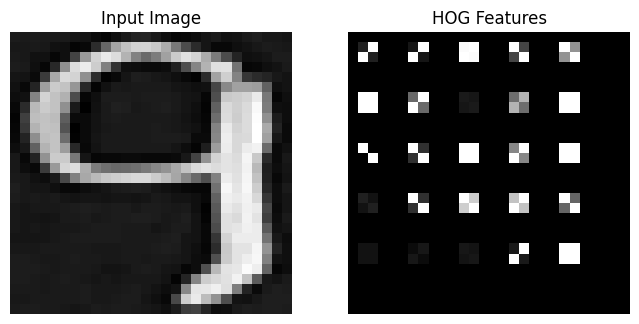

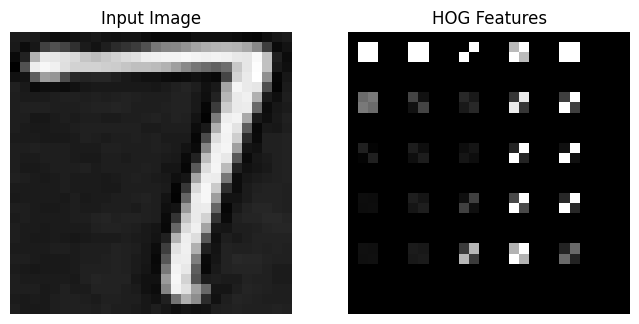

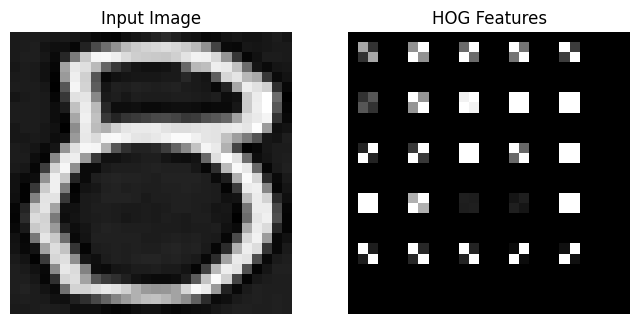

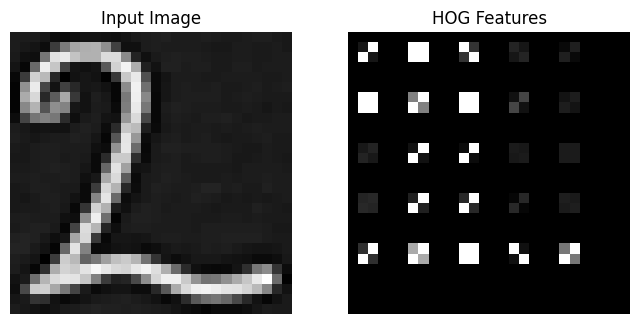

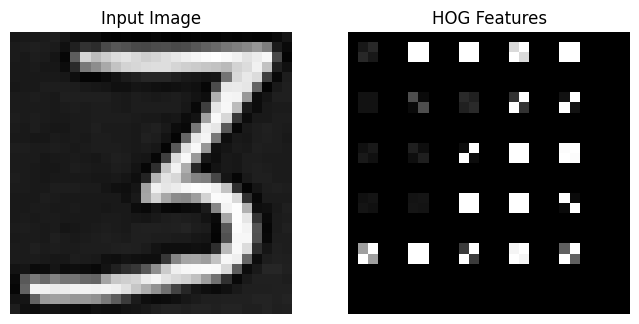

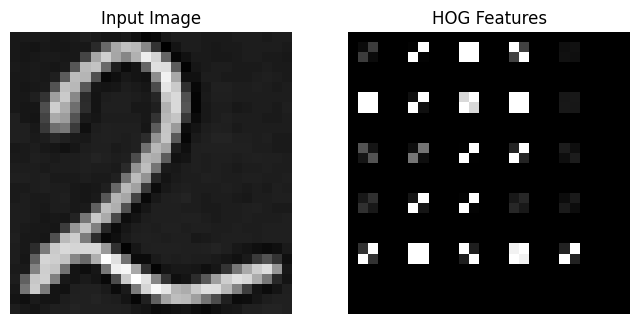

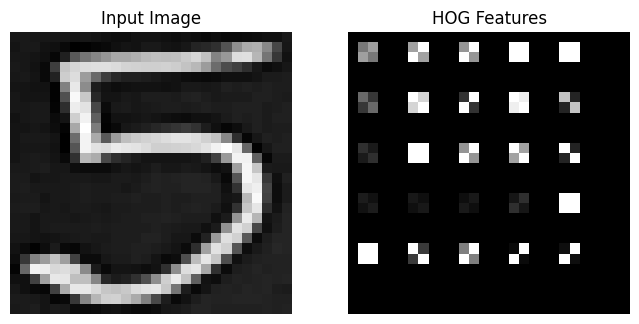

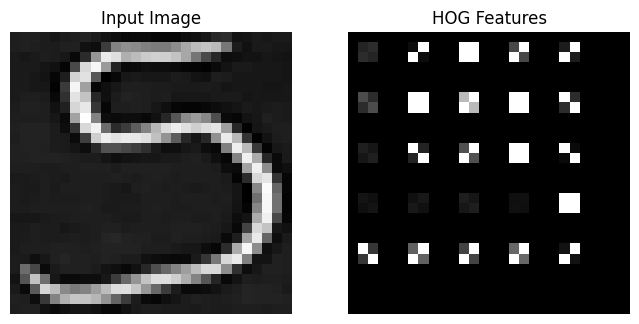

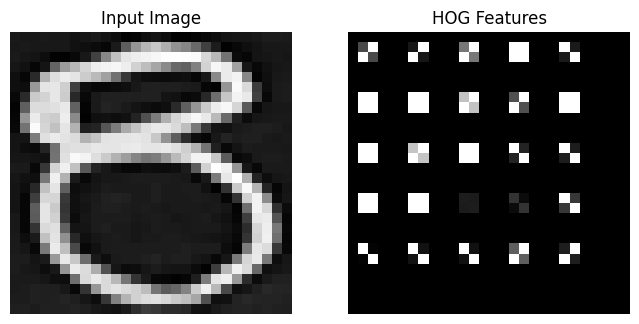

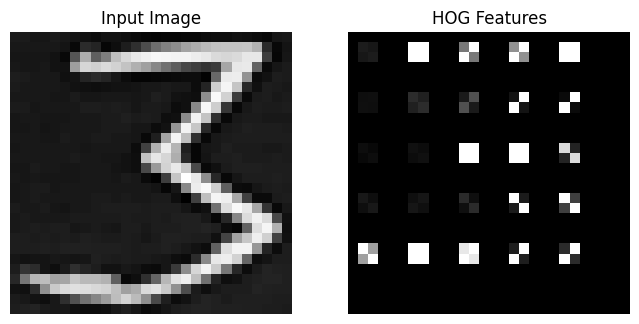

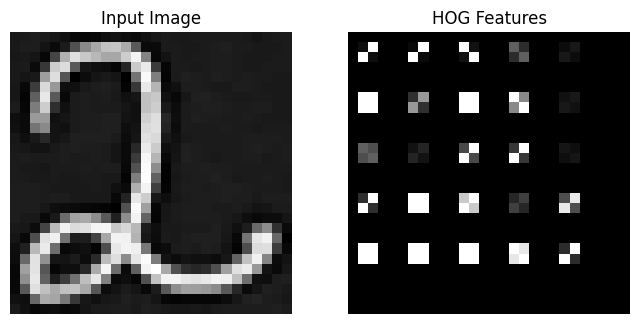

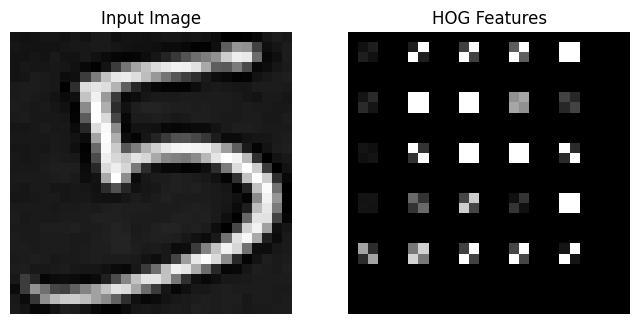

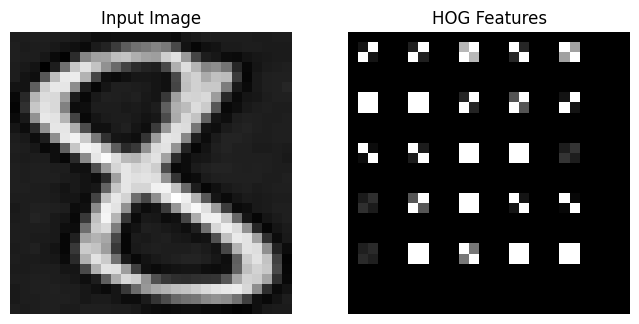

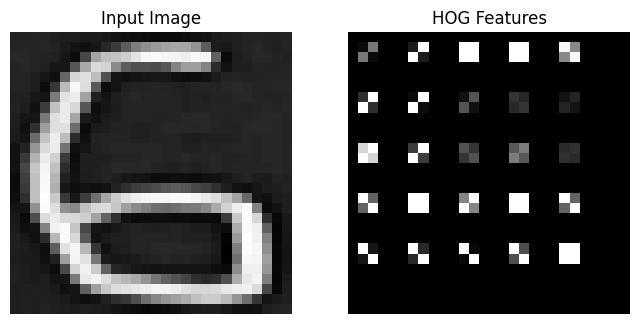

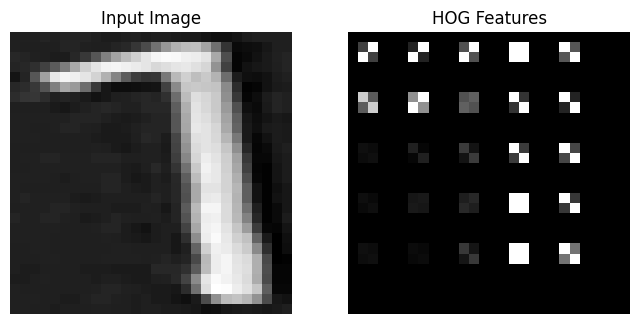

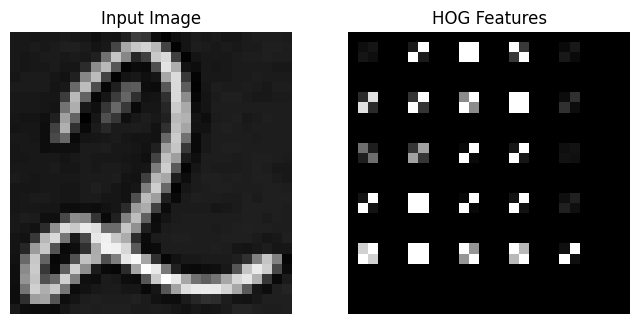

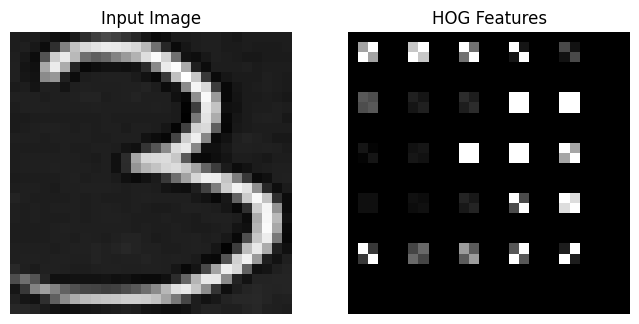

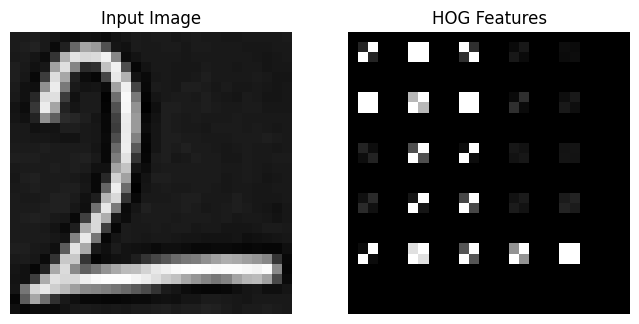

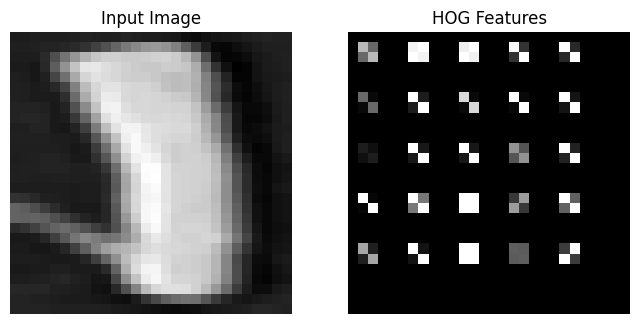

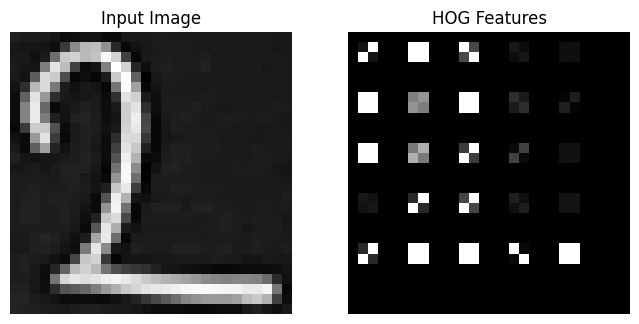

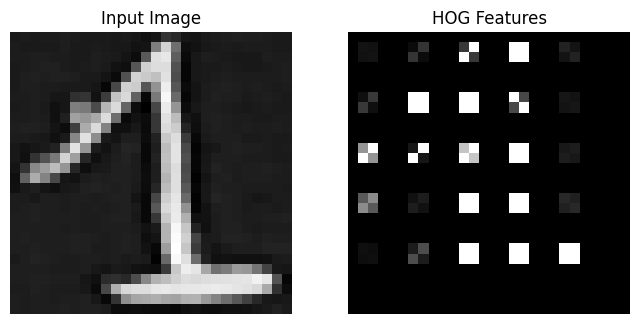

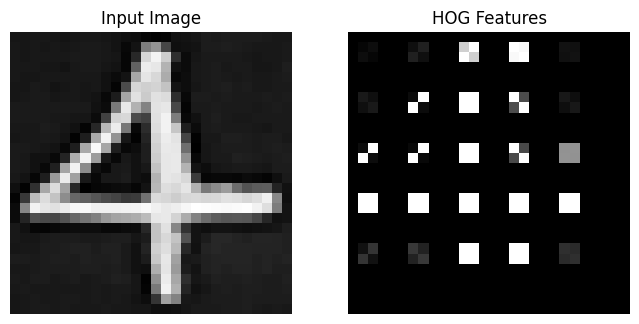

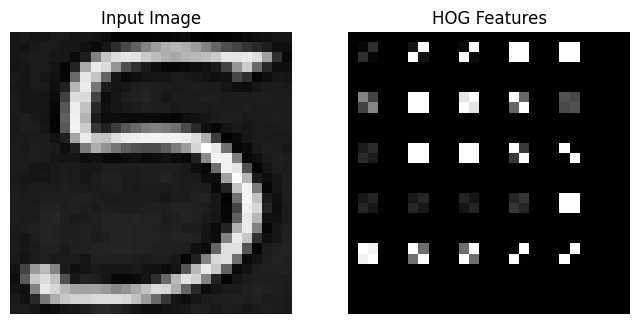

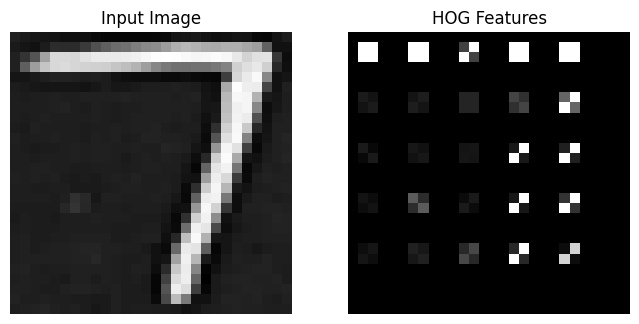

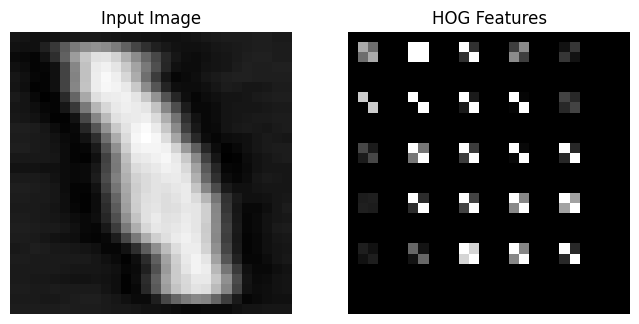

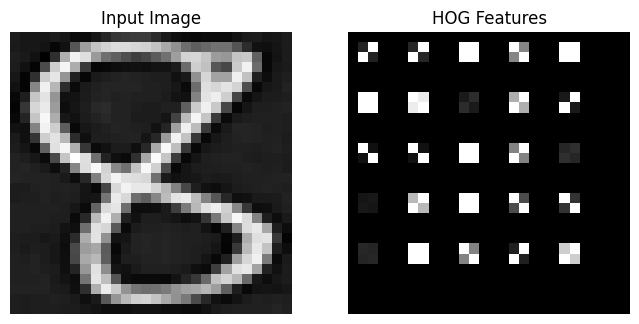

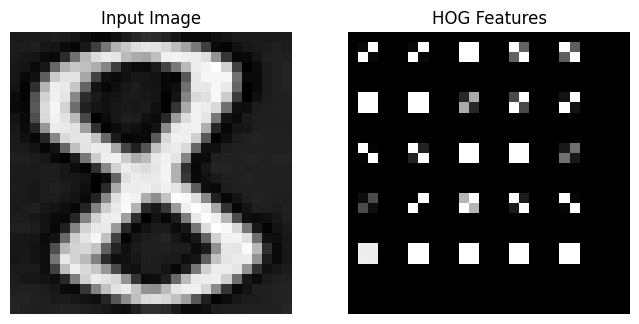

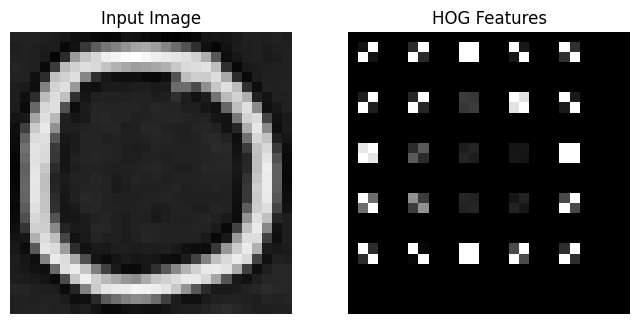

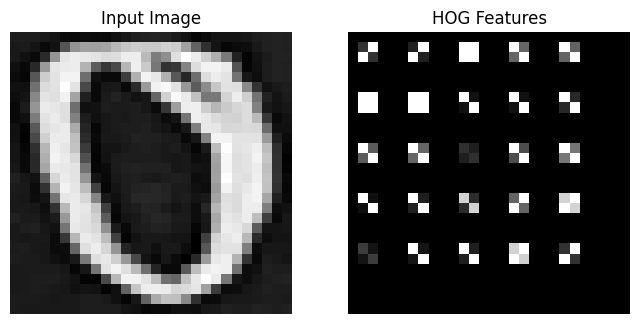

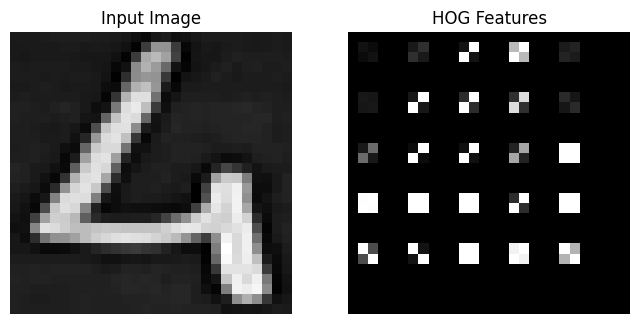

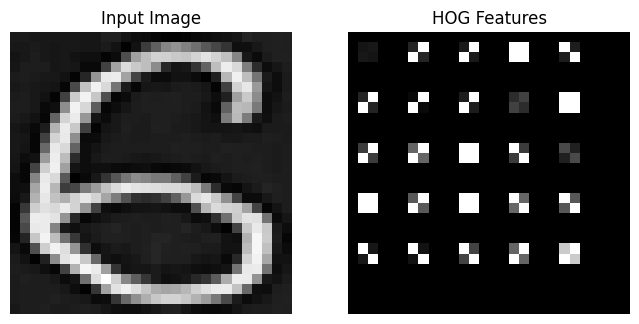

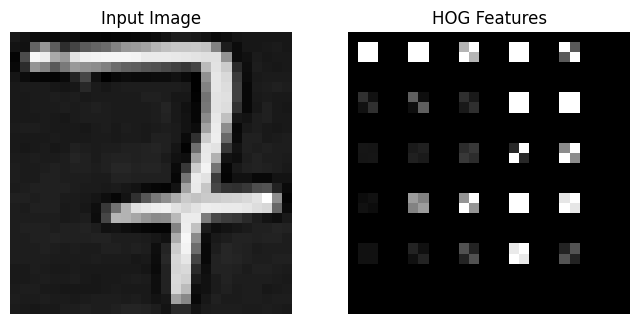

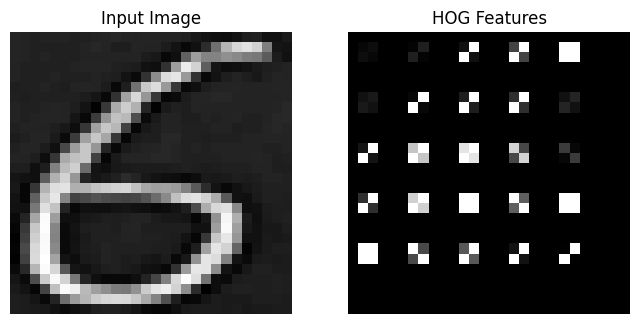

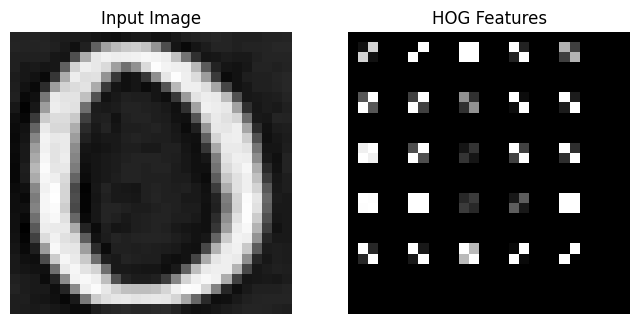

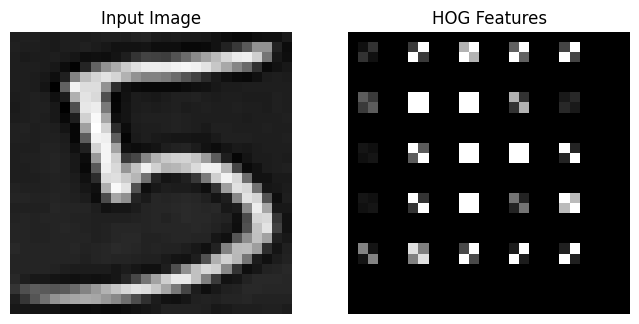

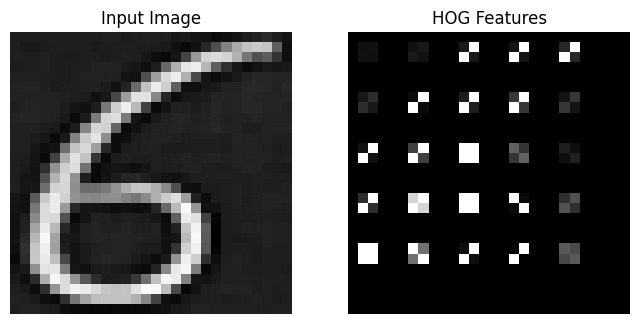

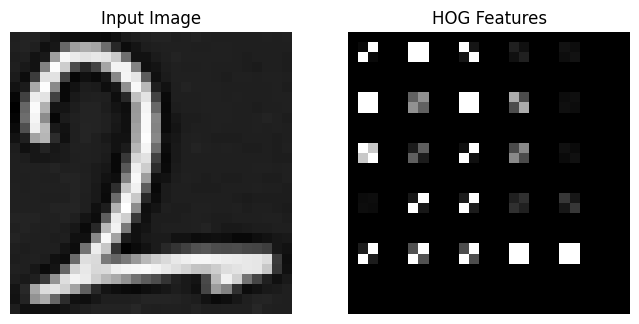

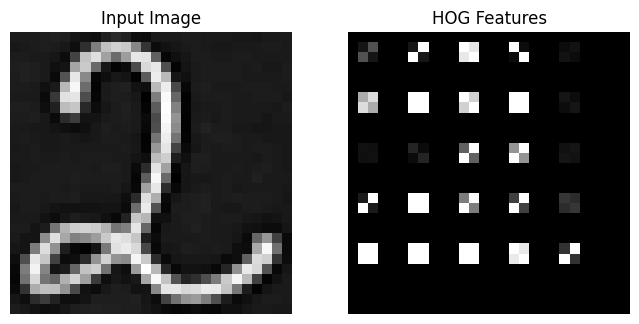

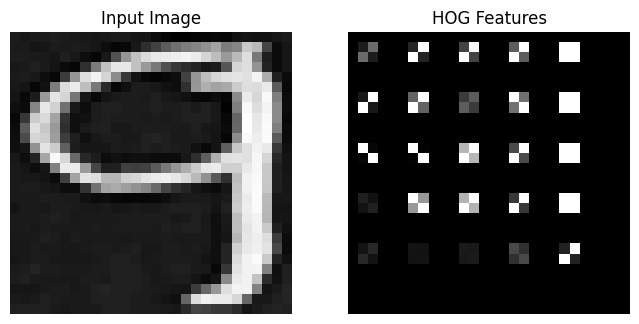

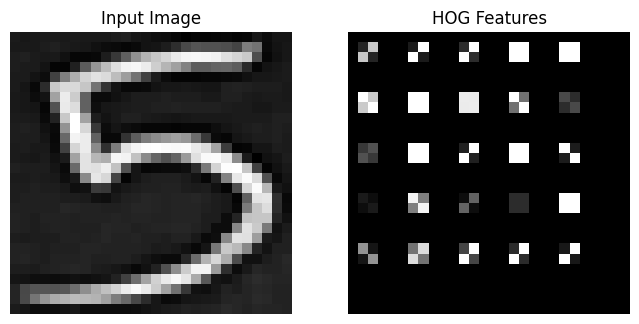

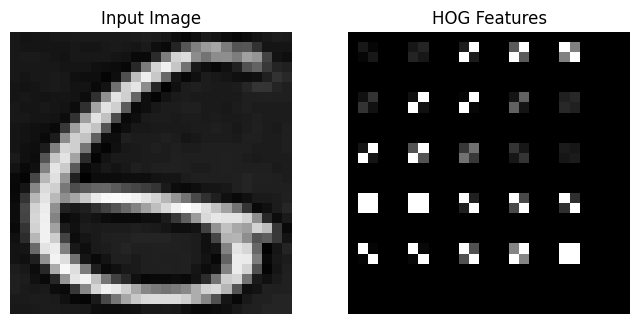

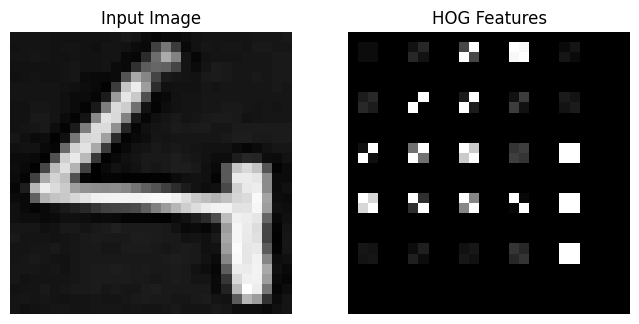

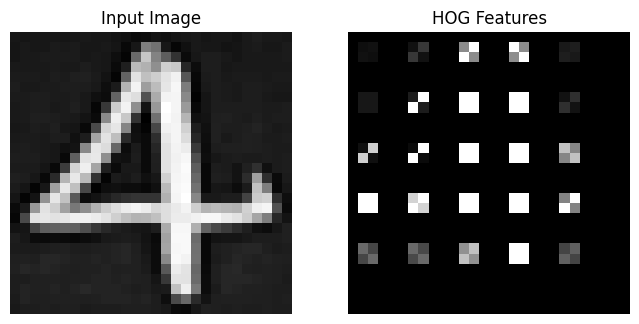

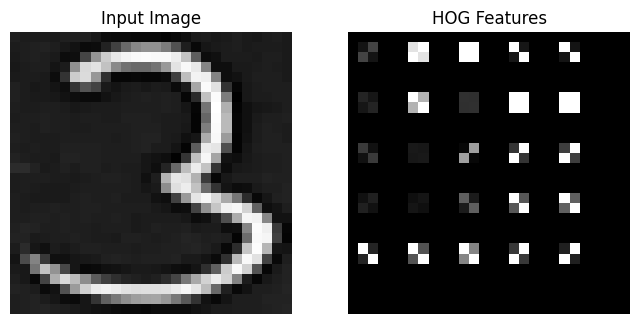

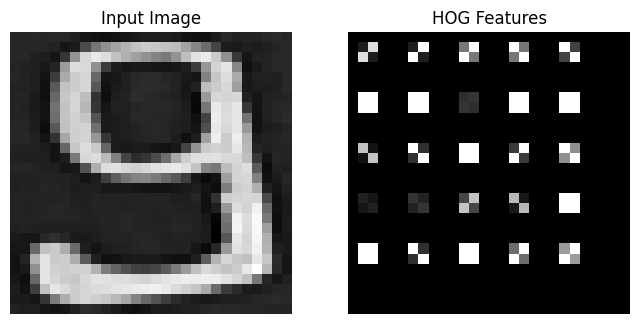

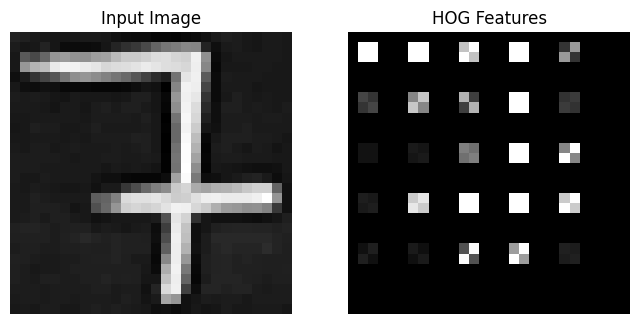

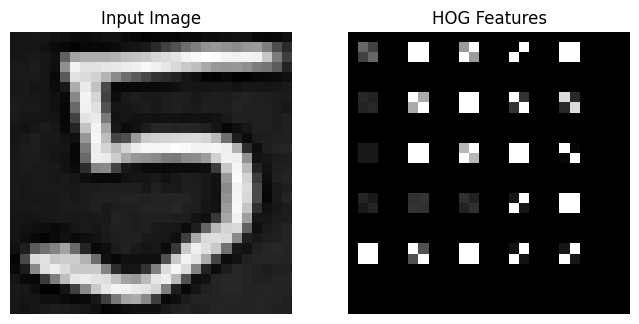

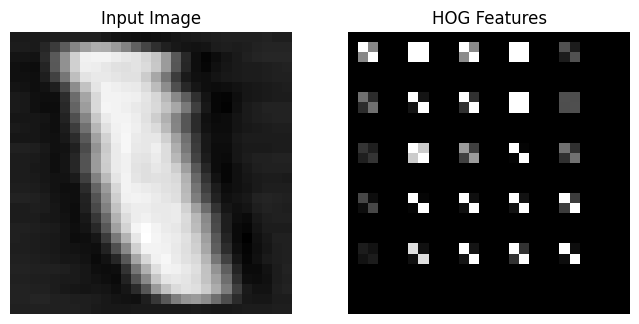

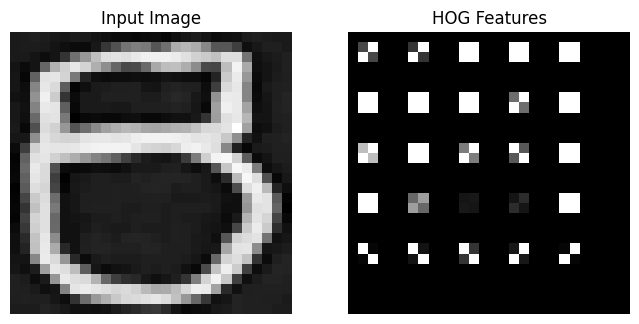

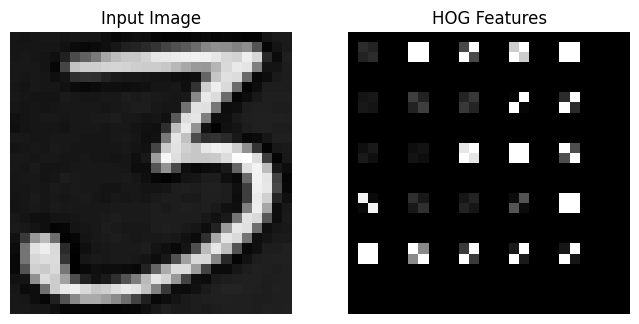

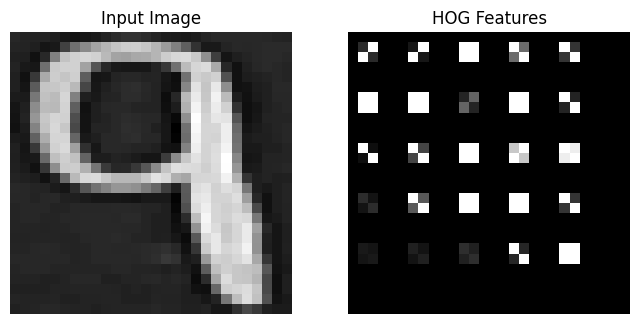

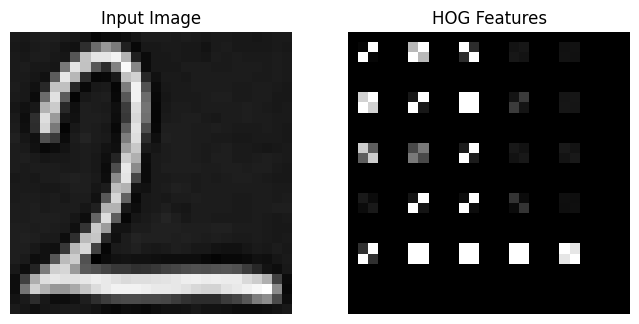

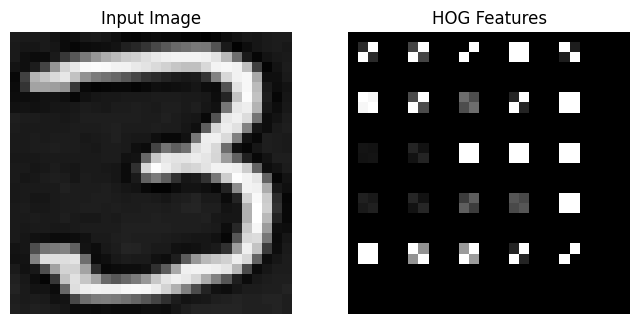

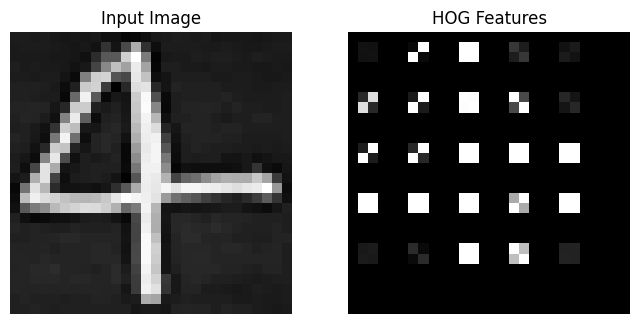

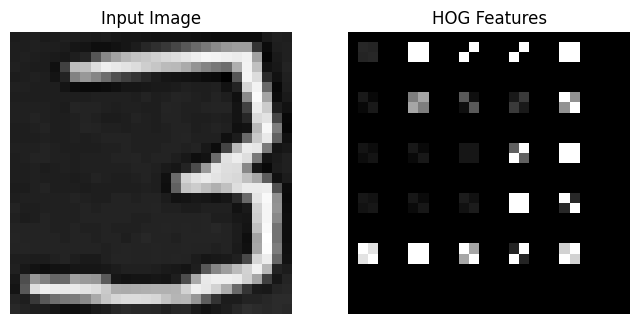

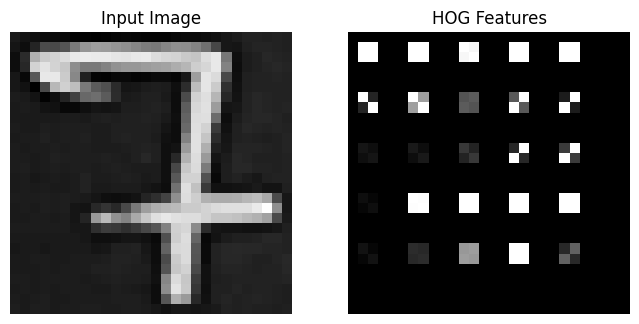

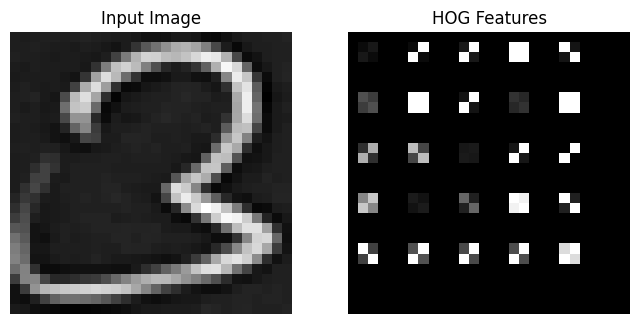

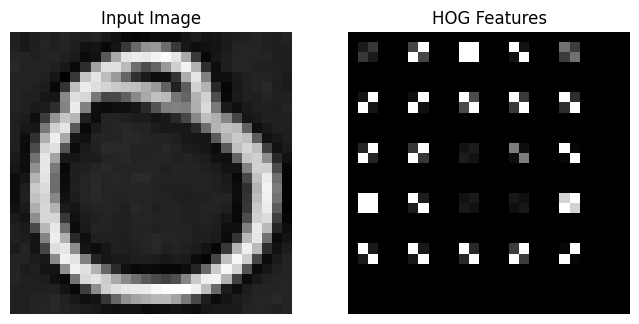

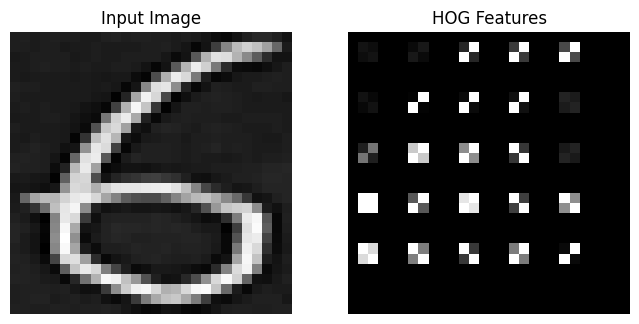

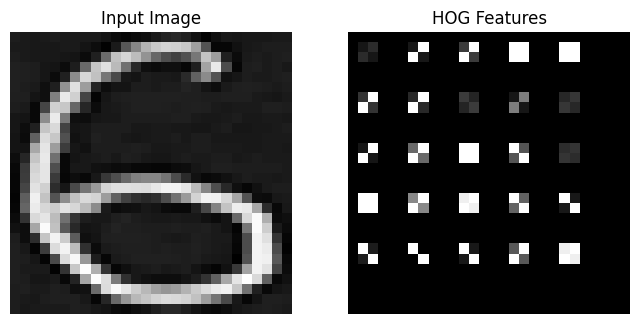

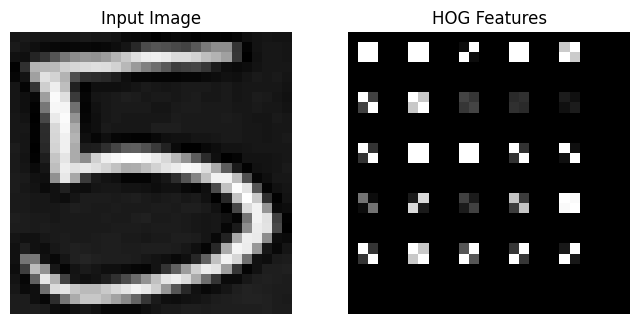

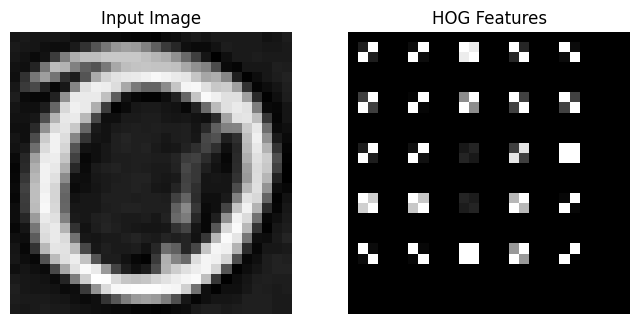

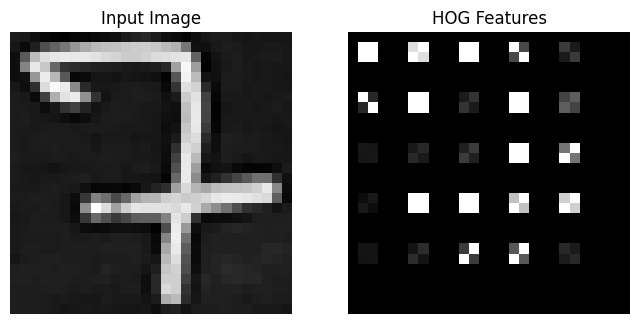

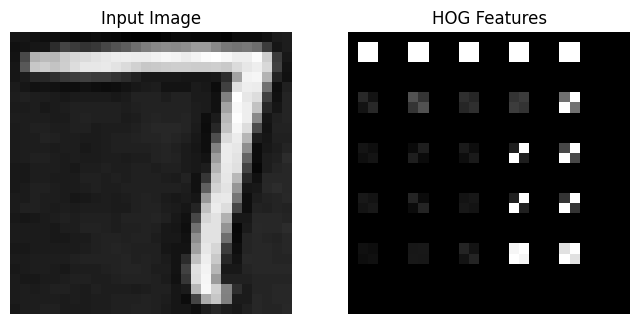

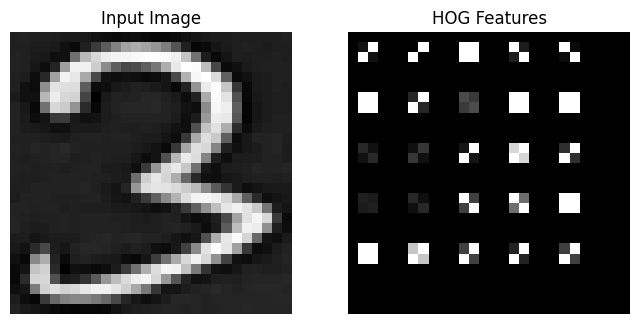

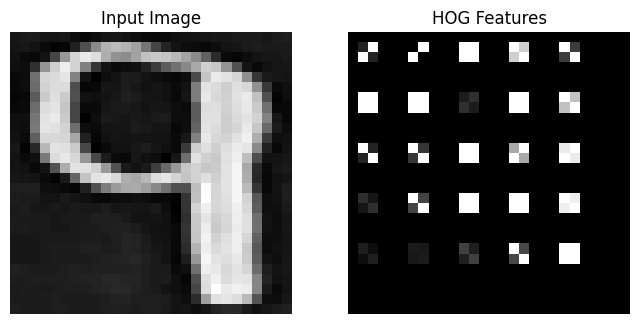

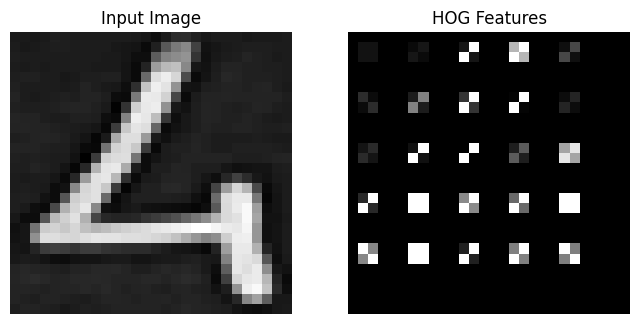

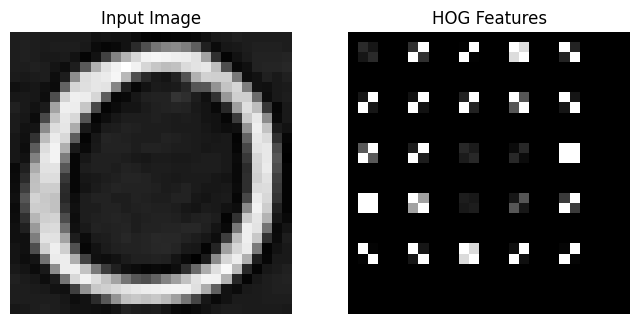

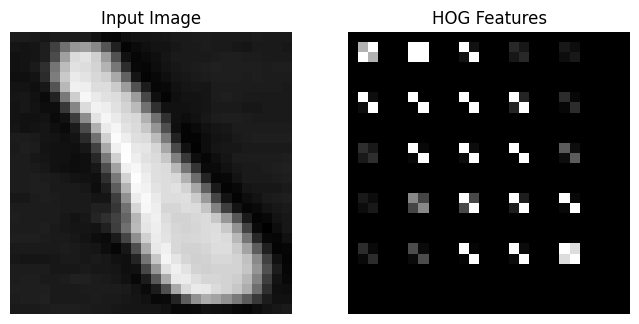

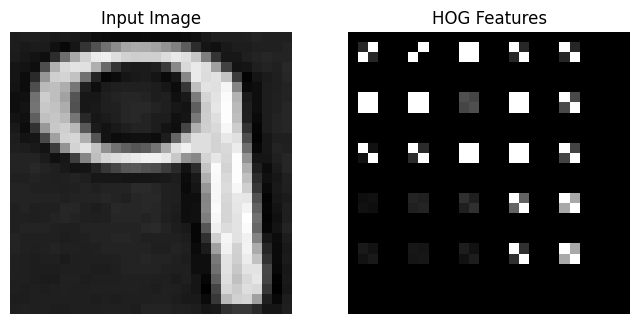

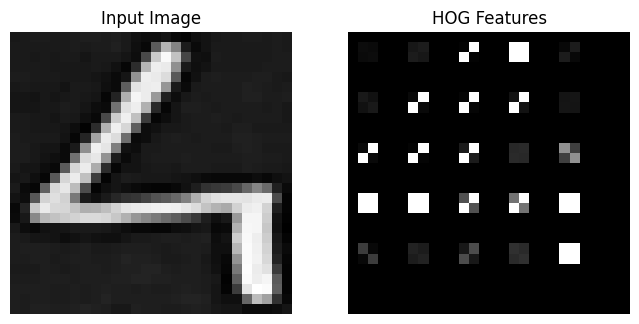

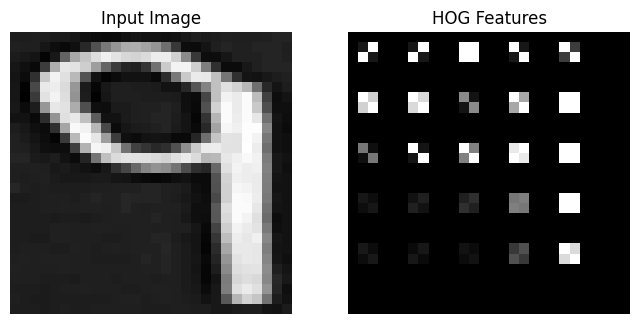

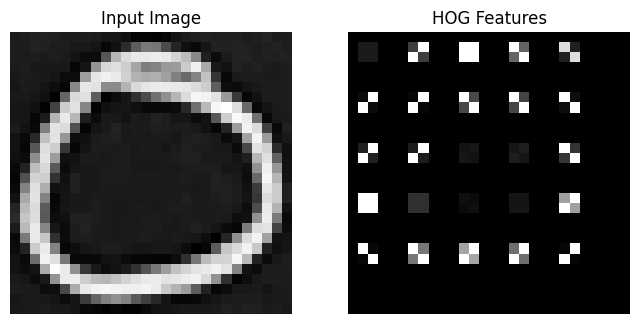

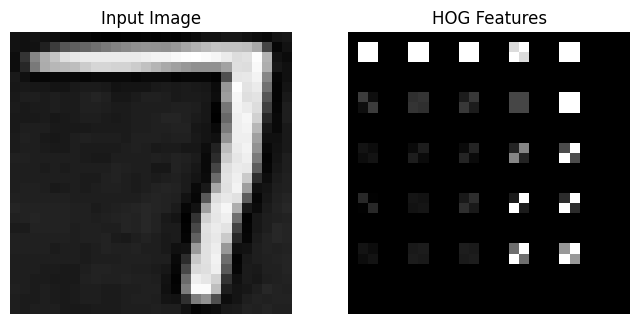

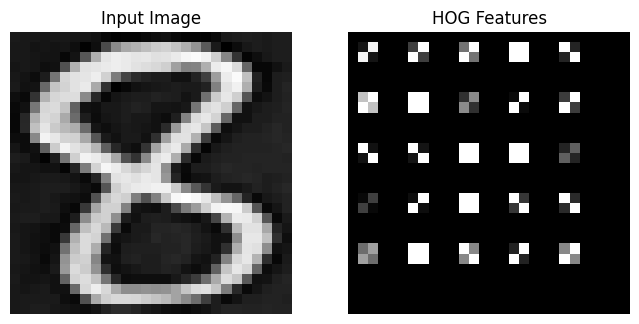

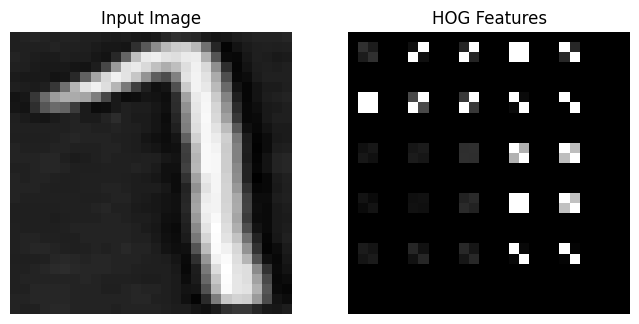

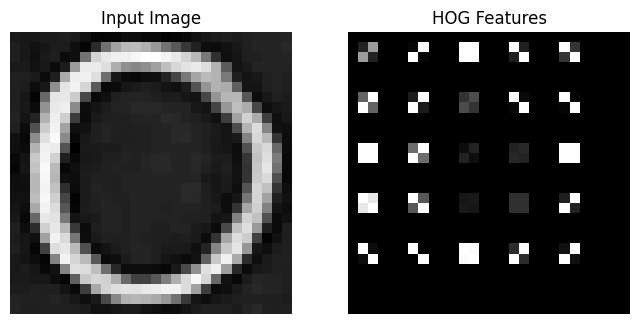

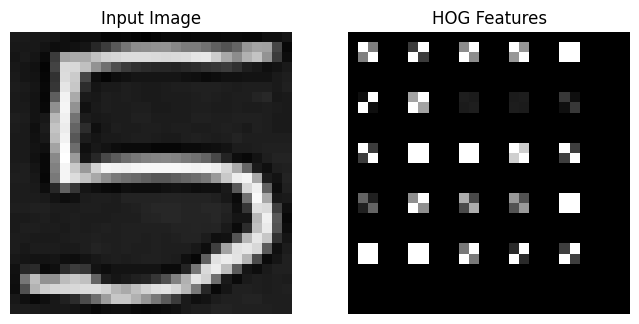

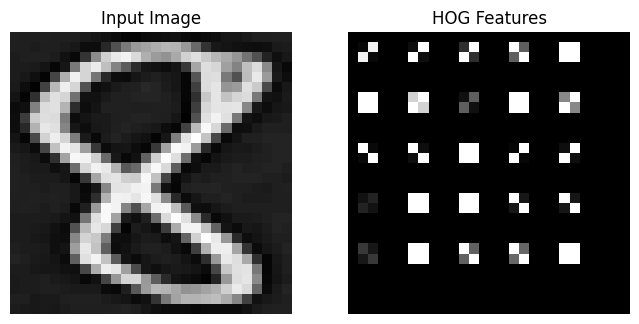

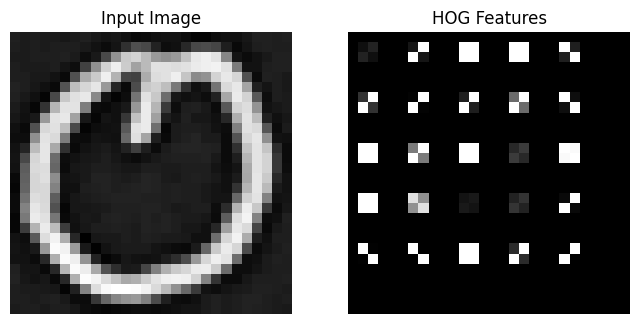

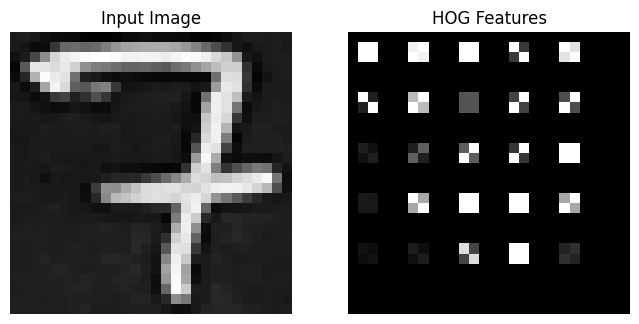

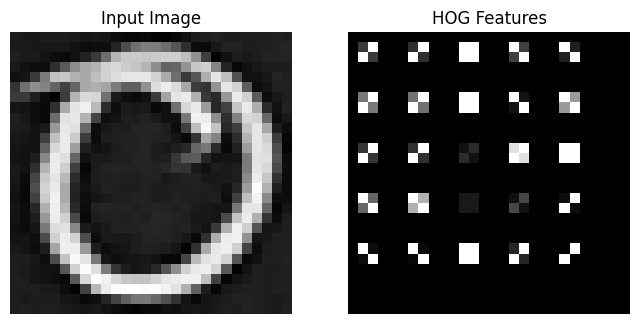

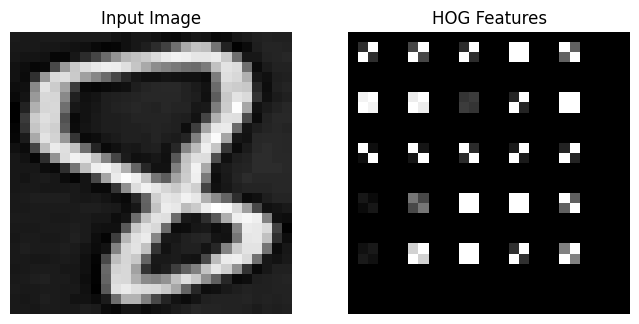

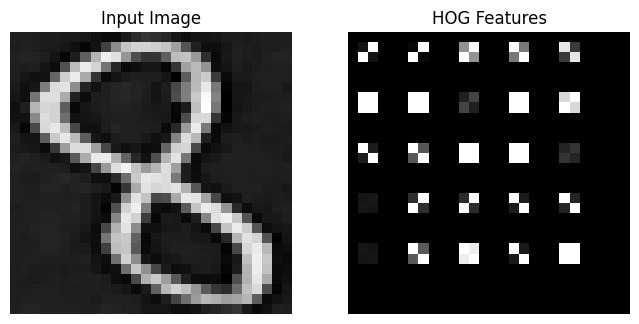

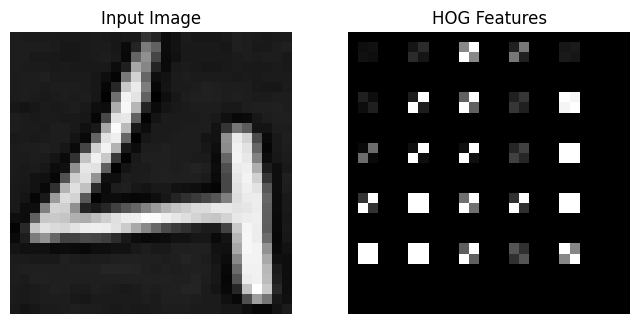

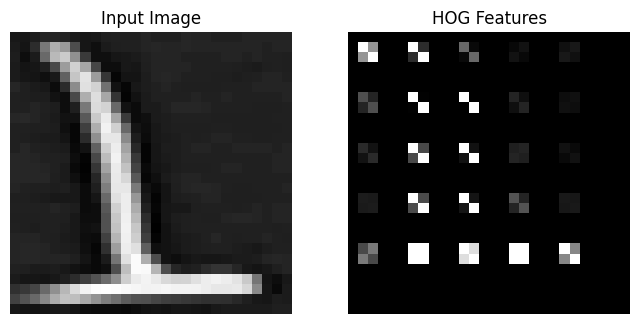

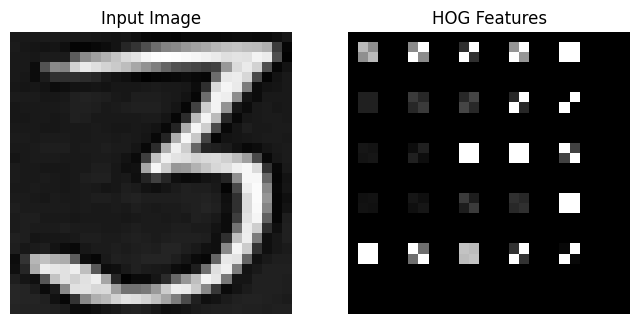

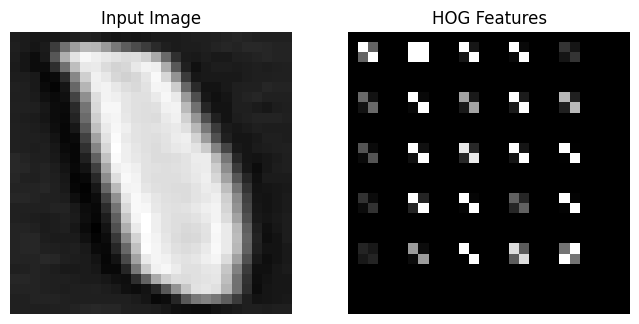

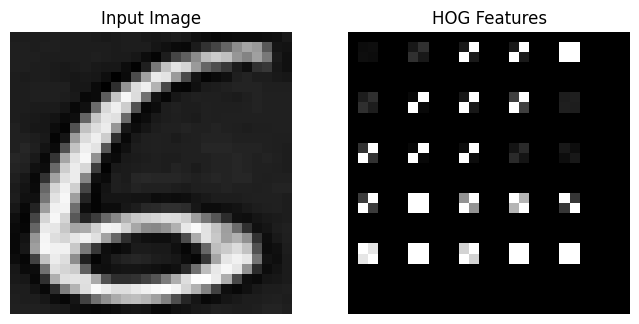

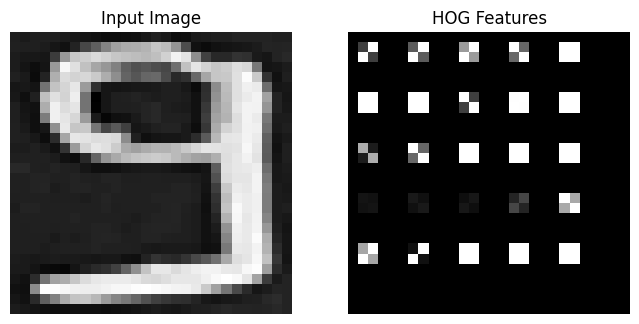

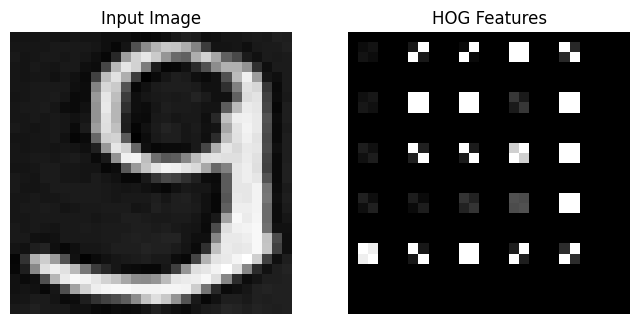

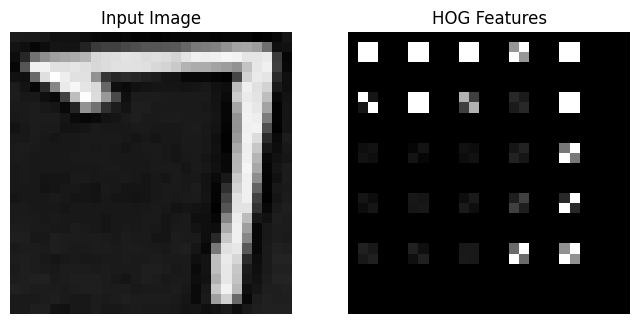

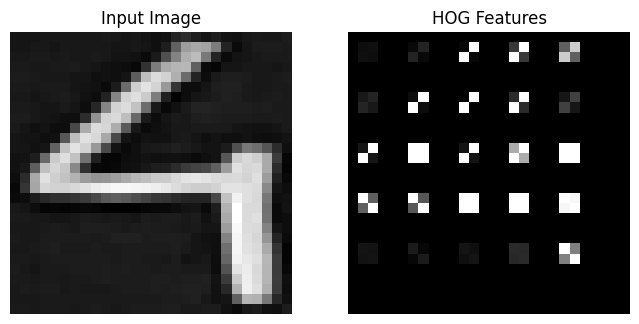

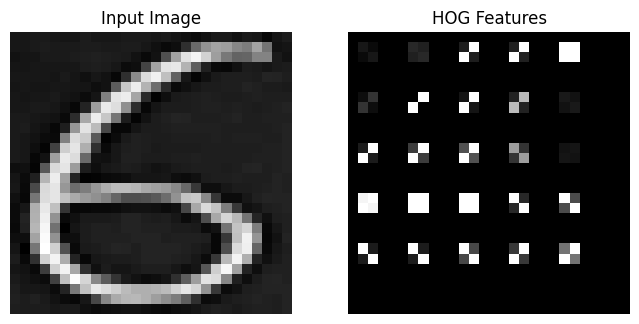

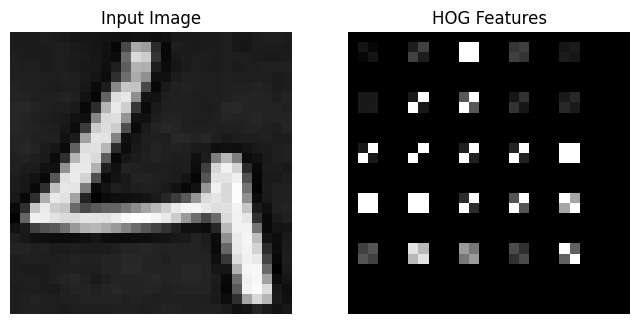

In [ ]:
from skimage import exposure

def plot_hog_features(img_array):
    for img in img_array:
        fd, hog_image = hog(img, orientations=10, pixels_per_cell=(5, 5), cells_per_block=(1, 1), visualize=True)
        # Plot the original image
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title('Input Image')
        plt.axis('off')
        # Plot the HOG features
        plt.subplot(1, 2, 2)
        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))  # Rescale intensity for better visualization
        plt.imshow(hog_image_rescaled, cmap='gray')
        plt.title('HOG Features')
        plt.axis('off')
        plt.show()

plot_hog_features(digits)


# HOG FEATURES FROM SCRATCH

---



[(645, 101, 23, 75), (921, 101, 49, 73), (1022, 103, 18, 60), (130, 104, 22, 70), (325, 105, 21, 59), (435, 106, 46, 68), (844, 106, 15, 63), (758, 107, 26, 67), (229, 108, 13, 61), (553, 108, 14, 65), (1020, 195, 54, 62), (939, 197, 48, 63), (838, 207, 56, 66), (548, 209, 51, 64), (751, 209, 57, 68), (225, 210, 56, 81), (655, 212, 55, 61), (329, 213, 53, 72), (441, 214, 64, 60), (123, 222, 52, 74), (1035, 302, 55, 86), (945, 314, 49, 66), (858, 322, 38, 58), (752, 326, 62, 77), (554, 329, 50, 76), (436, 332, 57, 70), (653, 332, 53, 65), (334, 338, 45, 58), (227, 339, 52, 67), (126, 347, 43, 56), (1035, 410, 68, 73), (959, 418, 37, 59), (863, 425, 42, 65), (767, 431, 38, 61), (445, 434, 42, 64), (656, 434, 51, 61), (553, 436, 46, 61), (329, 448, 51, 63), (235, 449, 39, 62), (132, 456, 35, 57), (1047, 500, 55, 75), (961, 508, 47, 66), (868, 518, 46, 62), (766, 520, 46, 67), (659, 531, 50, 69), (562, 534, 50, 70), (451, 538, 48, 73), (230, 552, 53, 70), (333, 553, 54, 74), (128, 564, 46,

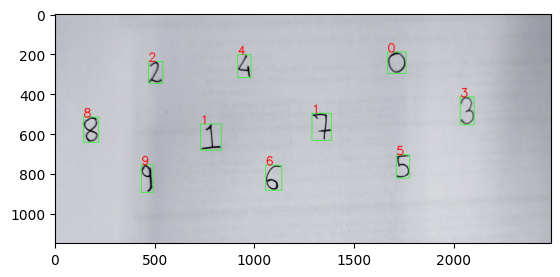

In [ ]:
from PIL import Image
from numpy import asarray

import numpy as np
from scipy.ndimage import convolve
from skimage.color import rgb2gray

def compute_gradients(image):
    # Convert image to grayscale
    gray_image = rgb2gray(image)

    # Sobel filters for horizontal and vertical gradients
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1],
                        [0, 0, 0],
                        [1, 2, 1]])

    # Compute gradients in x and y directions
    gradient_x = convolve(gray_image, sobel_x)
    gradient_y = convolve(gray_image, sobel_y)

    return gradient_x, gradient_y


def normalize_histogram(histogram, block_size=(2, 2), epsilon=1e-5):
    # Define block size
    block_height, block_width = block_size

    # Compute number of blocks in x and y directions
    num_blocks_x = histogram.shape[1] - block_width + 1
    num_blocks_y = histogram.shape[0] - block_height + 1

    # Initialize HOG feature vector
    hog_features = []

    # Normalize histogram for each block
    for i in range(num_blocks_y):
        for j in range(num_blocks_x):
            block_histogram = histogram[i: i + block_height, j: j + block_width, :].flatten()
            block_norm = np.sqrt(np.sum(block_histogram ** 2) + epsilon ** 2)
            hog_features.extend(block_histogram / block_norm)

    return hog_features

def pixels_to_hog_20(img_array):
    hog_featuresData = []
    for img in img_array:
        gradient_x, gradient_y = compute_gradients(img)
        histogram = compute_histogram(gradient_x, gradient_y)
        hog_features = normalize_histogram(histogram)
        hog_featuresData.append(hog_features)
    hog_features = np.array(hog_featuresData, 'float64')
    return np.float32(hog_features)

def imresize(arr,size):
	img=Image.fromarray(arr)
	img=img.resize(size)
	return asarray(img)

import numpy as np
# from scipy.misc.pilutil import imresize
from PIL import Image
import cv2  # version 3.2.0
from skimage.feature import hog
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

DIGIT_WIDTH = 10
DIGIT_HEIGHT = 20
IMG_HEIGHT = 28
IMG_WIDTH = 28
CLASS_N = 10  # 0-9


# This method splits the input training image into small cells (of a single digit) and uses these cells as training data.
# The default training image (MNIST) is a 1000x1000 size image and each digit is of size 10x20. so we divide 1000/10 horizontally and 1000/20 vertically.
def split2d(img, cell_size, flatten=True):
    h, w = img.shape[:2]
    sx, sy = cell_size
    cells = [np.hsplit(row, w // sx) for row in np.vsplit(img, h // sy)]
    cells = np.array(cells)
    if flatten:
        cells = cells.reshape(-1, sy, sx)
    return cells


def load_digits(fn):
    print('loading "%s for training" ...' % fn)
    digits_img = cv2.imread(fn, 0)
    digits = split2d(digits_img, (DIGIT_WIDTH, DIGIT_HEIGHT))
    resized_digits = []
    for digit in digits:
        resized_digits.append(imresize(digit, (IMG_WIDTH, IMG_HEIGHT)))
    labels = np.repeat(np.arange(CLASS_N), len(digits) / CLASS_N)
    return np.array(resized_digits), labels

# define a custom model in a similar class wrapper with train and predict methods
class KNN_MODEL():
    def __init__(self, k=3):
        self.k = k
        self.model = cv2.ml.KNearest_create()

    def train(self, samples, responses):
        self.model.train(samples, cv2.ml.ROW_SAMPLE, responses)

    def predict(self, samples):
        retval, results, neigh_resp, dists = self.model.findNearest(samples, self.k)
        return results.ravel()


class SVM_MODEL():
    def __init__(self, num_feats, C=1, gamma=0.1):
        self.model = cv2.ml.SVM_create()
        self.model.setType(cv2.ml.SVM_C_SVC)
        self.model.setKernel(cv2.ml.SVM_RBF)  # SVM_LINEAR, SVM_RBF
        self.model.setC(C)
        self.model.setGamma(gamma)
        self.features = num_feats

    def train(self, samples, responses):
        self.model.train(samples, cv2.ml.ROW_SAMPLE, responses)

    def predict(self, samples):
        results = self.model.predict(samples.reshape(-1, self.features))
        return results[1].ravel()


def get_digits(contours, hierarchy):
    hierarchy = hierarchy[0]
    bounding_rectangles = [cv2.boundingRect(ctr) for ctr in contours]
    final_bounding_rectangles = []
    # find the most common heirarchy level - that is where our digits's bounding boxes are
    u, indices = np.unique(hierarchy[:, -1], return_inverse=True)
    most_common_heirarchy = u[np.argmax(np.bincount(indices))]

    for r, hr in zip(bounding_rectangles, hierarchy):
        x, y, w, h = r

        if ((w * h) > 250) and (10 <= w <= 200) and (10 <= h <= 200) and hr[3] == most_common_heirarchy:
            final_bounding_rectangles.append(r)

    return final_bounding_rectangles


def proc_user_img(img_file, model):
    print('loading "%s for digit recognition" ...' % img_file)
    im = cv2.imread(img_file)
    blank_image = np.zeros((im.shape[0], im.shape[1], 3), np.uint8)
    blank_image.fill(255)

    imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    plt.imshow(imgray)
    kernel = np.ones((5, 5), np.uint8)

    ret, thresh = cv2.threshold(imgray, 127, 255, 0)
    thresh = cv2.erode(thresh, kernel, iterations=1)
    thresh = cv2.dilate(thresh, kernel, iterations=1)
    thresh = cv2.erode(thresh, kernel, iterations=1)

    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    digits_rectangles = get_digits(contours, hierarchy)  # rectangles of bounding the digits in user image

    for rect in digits_rectangles:
        x, y, w, h = rect
        cv2.rectangle(im, (x, y), (x + w, y + h), (0, 255, 0), 2)
        im_digit = imgray[y:y + h, x:x + w]
        im_digit = (255 - im_digit)
        im_digit = imresize(im_digit, (IMG_WIDTH, IMG_HEIGHT))

        hog_img_data = pixels_to_hog_20([im_digit])
        pred = model.predict(hog_img_data)
        cv2.putText(im, str(int(pred[0])), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 3)
        cv2.putText(blank_image, str(int(pred[0])), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 0, 0), 5)

    plt.imshow(im)
    cv2.imwrite("original_overlay.png", im)
    cv2.imwrite("final_digits.png", blank_image)
    # cv2.destroyAllWindows()


def get_contour_precedence(contour, cols):
    return contour[1] * cols + contour[0]  # row-wise ordering

def load_digits_custom(img_file):
    train_data = []
    train_target = []
    start_class = 1
    im = cv2.imread(img_file)
    imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    plt.imshow(imgray)
    kernel = np.ones((5, 5), np.uint8)

    ret, thresh = cv2.threshold(imgray, 127, 255, 0)
    thresh = cv2.erode(thresh, kernel, iterations=1)
    thresh = cv2.dilate(thresh, kernel, iterations=1)
    thresh = cv2.erode(thresh, kernel, iterations=1)

    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    digits_rectangles = get_digits(contours, hierarchy)  # rectangles of bounding the digits in user image

    # sort rectangles accoring to x,y pos so that we can label them
    digits_rectangles.sort(key=lambda x: get_contour_precedence(x, im.shape[1]))
    print(digits_rectangles)
    for index, rect in enumerate(digits_rectangles):
        x, y, w, h = rect
        cv2.rectangle(im, (x, y), (x + w, y + h), (0, 255, 0), 2)
        im_digit = imgray[y:y + h, x:x + w]
        im_digit = (255 - im_digit)

        im_digit = imresize(im_digit, (IMG_WIDTH, IMG_HEIGHT))
        train_data.append(im_digit)
        train_target.append(start_class % 10)

        if index > 0 and (index + 1) % 10 ==0:
            start_class += 1
    cv2.imwrite("training_box_overlay.png", im)

    return np.array(train_data), np.array(train_target)


# ------------------data preparation--------------------------------------------

TRAIN_MNIST_IMG = '/content/digits.png'
TRAIN_USER_IMG = '/content/custom_train_digits_k1.jpg'
TEST_USER_IMG = '/content/handwritten_testing_keshavjpg.jpg'

# digits, labels = load_digits(TRAIN_MNIST_IMG) #original MNIST data (not good detection)
digits, labels = load_digits_custom(
    TRAIN_USER_IMG)  # my handwritten dataset (better than MNIST on my handwritten digits)

print('train data shape', digits.shape)
print('test data shape', labels.shape)

digits, labels = shuffle(digits, labels, random_state=256)
train_digits_data = pixels_to_hog_20(digits)
X_train, X_test, y_train, y_test = train_test_split(train_digits_data, labels, test_size=0.33, random_state=42)

# ------------------training and testing----------------------------------------

model = KNN_MODEL(k=3)
model.train(X_train, y_train)
preds = model.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, preds))

model = KNN_MODEL(k=4)
model.train(train_digits_data, labels)
proc_user_img(TEST_USER_IMG, model)

# model = SVM_MODEL(num_feats=train_digits_data.shape[1])
# model.train(X_train, y_train)
# preds = model.predict(X_test)
# print('Accuracy: ', accuracy_score(y_test, preds))

# model = SVM_MODEL(num_feats=train_digits_data.shape[1])
# model.train(train_digits_data, labels)
# proc_user_img(TEST_USER_IMG, model)

# USING DEEP LEARNING

---




Epoch 1/5
750/750 [==============================] - 43s 50ms/step - loss: 0.2121 - accuracy: 0.9342 - val_loss: 0.0703 - val_accuracy: 0.9797
Epoch 2/5
750/750 [==============================] - 39s 51ms/step - loss: 0.0569 - accuracy: 0.9825 - val_loss: 0.0453 - val_accuracy: 0.9867
Epoch 3/5
750/750 [==============================] - 38s 51ms/step - loss: 0.0391 - accuracy: 0.9874 - val_loss: 0.0498 - val_accuracy: 0.9854
Epoch 4/5
750/750 [==============================] - 37s 50ms/step - loss: 0.0297 - accuracy: 0.9908 - val_loss: 0.0655 - val_accuracy: 0.9812
Epoch 5/5
313/313 [==============================] - 2s 8ms/step - loss: 0.0359 - accuracy: 0.9881
Test accuracy: 0.988099992275238


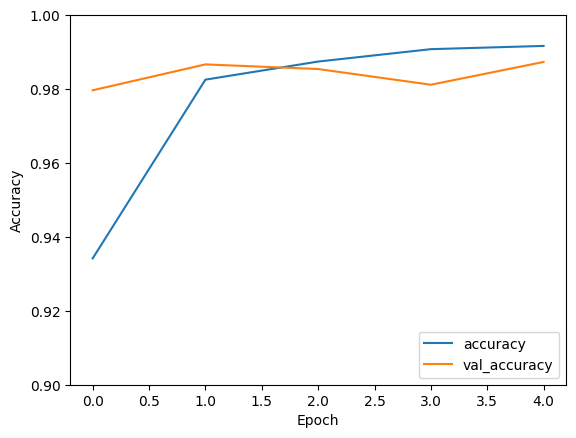

In [ ]:


import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.datasets import mnist
from keras.utils import to_categorical

# Load and preprocess the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize pixel values to be between 0 and 1
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

# Reshape images to have a single channel (grayscale)
train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

# One-hot encode the labels
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)


class Conv2DLayer(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, strides=(1, 1), padding='valid'):
        super(Conv2DLayer, self).__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding

    def build(self, input_shape):
        self.kernel = self.add_weight("kernel",
                                      shape=(self.kernel_size[0], self.kernel_size[1], input_shape[-1], self.filters),
                                      initializer='glorot_uniform',
                                      trainable=True)

    def call(self, inputs):
        padding = [[0, 0], [0, 0], [0, 0], [0, 0]]
        if self.padding == 'same':
            input_shape = tf.shape(inputs)
            height_pad = max((self.kernel_size[0] - self.strides[0]) // 2, 0)
            width_pad = max((self.kernel_size[1] - self.strides[1]) // 2, 0)
            padding = [[0, 0], [height_pad, height_pad], [width_pad, width_pad], [0, 0]]
            inputs = tf.pad(inputs, padding)

        output = self.custom_conv2d(inputs, self.kernel, strides=[1, self.strides[0], self.strides[1], 1], padding='VALID')
        return output

    def custom_conv2d(self, inputs, kernel, strides, padding):
        output = tf.nn.conv2d(inputs, kernel, strides=strides, padding=padding)
        return output

# Define the model architecture using the custom Conv2D layer
model = tf.keras.Sequential([
    Conv2DLayer(32, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    Conv2DLayer(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    Conv2DLayer(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_images, train_labels, epochs=5, batch_size=64, validation_split=0.2)

# Evaluate the model on test set
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

# Plot training and validation accuracy over epochs
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.9, 1])
plt.legend(loc='lower right')
plt.show()
